In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import os
import glob
import itertools

%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):


In [3]:
#first get shuffled population
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
fpf.generate_shuffle_population(mice=mice, proj_folder= "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq", total_number_shuffles= 100000, mice_sep=True, use_slurm=False)


collate_all_shuffles= 15894059


In [92]:
#fpf.collate_all_shuffles(temp_shuffle_folder='/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/temp_shuffles', mice_sep=False, mice=['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d'], overwrite=False, use_slurm=False, )

In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, binary=True, IT_only=True, area_threshold=0.1)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, binary=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False, binary=True,  IT_only=True)
    new_dict['shuff_cubelet']= fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=True, IT_only=True)
    new_dict['shuff_area']=fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=False,  IT_only=True)
    new_dict['shuff_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=True,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

In [3]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'shuff_cubelet']
for key in analysis_names:
    cols = ['VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISal', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy()
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    if 'shuff' in key:
        which = key.split('shuff_')[-1]
        #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        if which in ('cubelet', 'area'):
            matrix_to_comp = all_combined[f'homogenous_across_{which}']
        elif which == 'main':
            matrix_to_comp= all_combined['area_is_main']
        conditional_prob = fpf.get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
        shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
        mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for column_name in shuffled_cond_prob.columns:
            separated_words = column_name.split(', ')
            mean_corr = shuffled_cond_prob[column_name].mean()
            if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
                # if separated_words[1] in cols:
                #     mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
                val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
                if val_to_comp >= mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                elif val_to_comp < mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                # if separated_words[1] in cols_reordered:
                #     p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        np.fill_diagonal(mean_val_matrix.values, np.nan)
        np.fill_diagonal(p_val_matrix.values, np.nan)
        number_tests = len(cols)* (len(cols_reordered)-1)
        p_val_matrix = p_val_matrix*number_tests #bonferroni correction
        p_val_dict[key] =p_val_matrix
        conditional_probability_dict[key] =mean_val_matrix
    else:
       conditional_probability_dict[key] = fpf.get_cond_prob(matrix=all_combined[key][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    

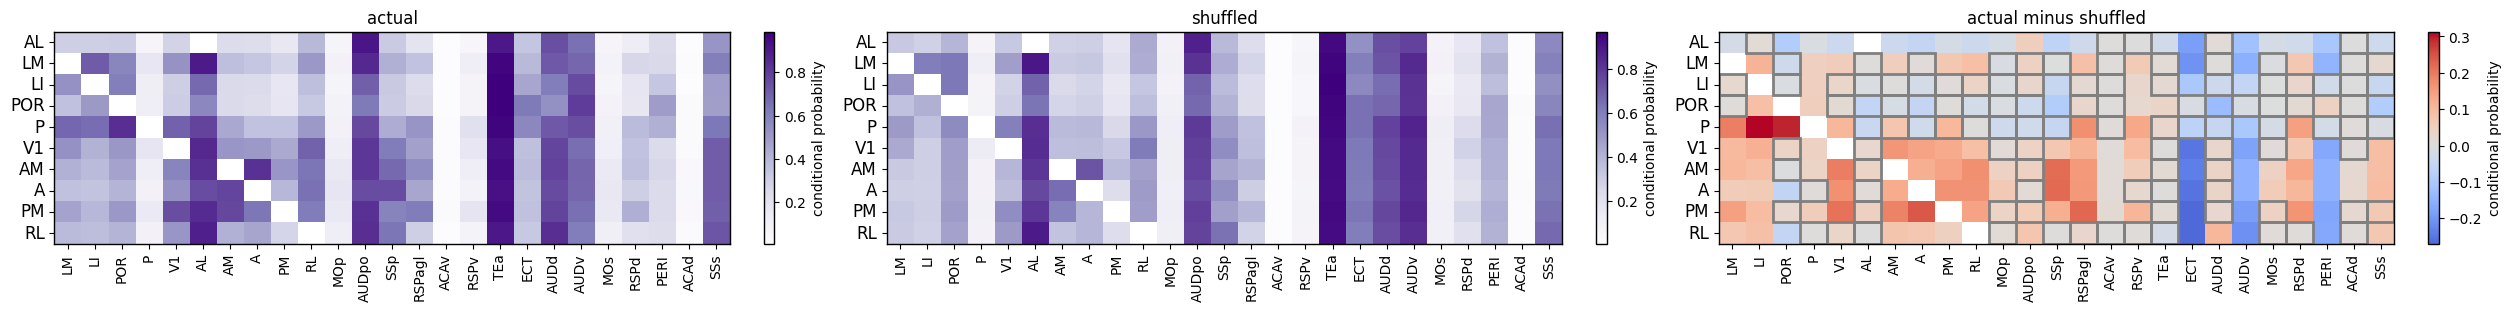

In [4]:

#analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(1, 3, figsize=(25, 3), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data_names_the_same = data_to_use.loc[cols].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        axs[number].set_title(f'{titles[number]}')
        axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if analysis_type != 'main':
            if number>1:
                for ii in shortened_data_names_the_same.index:
                    for j in shortened_data_names_the_same.columns:
                        if p_val_dict[f'shuff_cubelet'].loc[ii, j] > 0.05:
                            row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                            col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                            axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
        for _, spine in axs[number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

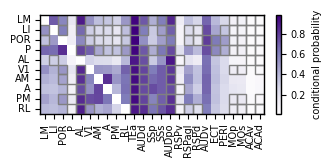

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram
plt.figure(figsize=(3.2, 1.5), constrained_layout=True)

analysis_type = 'cubelet'

if analysis_type != 'main':
    actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
elif analysis_type == 'main':
    actual_data = conditional_probability_dict['area_is_main']

cols = [ 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISal', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#all_cols = actual_data.columns
pairwise_distances = actual_data.corr() 
linkage_matrix = linkage(pairwise_distances, method='ward')
dendro = dendrogram(linkage_matrix, labels=actual_data.columns, no_plot=True)
column_order = dendro['ivl']
all_cols = column_order
cols = [col for col in cols if col in all_cols]
not_in = [col for col in all_cols if col not in cols]
combined = cols + not_in
shortened_data = actual_data.loc[cols][combined]
shortened_data_names_the_same = actual_data.loc[cols][combined].copy(deep=True)
sb.heatmap(
    data=fpf.convert_matrix_names(shortened_data), 
    cmap='Purples',
    xticklabels=True, 
    yticklabels=True, 
    cbar_kws={'label': 'conditional probability'}
)


plt.tick_params(axis='y', which='major', labelsize=7, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=7, rotation=90)
ax = plt.gca()  # Get the current axis for further adjustments
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('conditional probability', fontsize=7)
for ii in shortened_data_names_the_same.index:
    for j in shortened_data_names_the_same.columns:
        if p_val_dict[f'shuff_cubelet'].loc[ii, j] > 0.05:
            row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
            col_idx = shortened_data_names_the_same.columns.get_loc(j)  
            ax.add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=1))
plt.show()


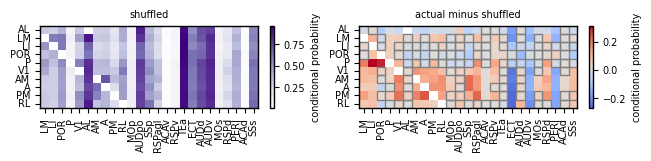

In [6]:
#plot shuffled 

#analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(1, 2, figsize=(6.4, 1.5), constrained_layout=True)

titles = ['shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data_names_the_same = data_to_use.loc[cols].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>0:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        
        axs[number].set_title(f'{titles[number]}', size =7)
        axs[number].tick_params(axis='y', which='major', labelsize=7, rotation=0)
        axs[number].tick_params(axis='x', which='major', labelsize=7, rotation=90)
        if analysis_type != 'main':
            if number>0:
                for ii in shortened_data_names_the_same.index:
                    for j in shortened_data_names_the_same.columns:
                        if p_val_dict[f'shuff_cubelet'].loc[ii, j] > 0.05:
                            row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                            col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                            axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=1))
        for _, spine in axs[number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)
        cbar.ax.tick_params(labelsize=7)
        cbar.set_label('conditional probability', fontsize=7)

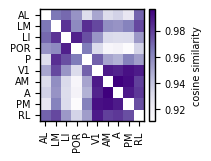

In [7]:
#plot cosine similarity
plt.figure(figsize=(2, 1.5), constrained_layout=True)

analysis_type = 'cubelet'

if analysis_type != 'main':
    actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
elif analysis_type == 'main':
    actual_data = conditional_probability_dict['area_is_main']

cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
all_cols = actual_data.columns
cols = [col for col in cols if col in all_cols]

shortened_data = actual_data.loc[cols]
shortened_data_names_the_same = actual_data.loc[cols].copy(deep=True)
cosine_sim_mat = fpf.get_cosine_sim_of_probs(actual_data, cols)
sb.heatmap(
    data=fpf.convert_matrix_names(cosine_sim_mat), 
    cmap='Purples',
    xticklabels=True, 
    yticklabels=True, 
    cbar_kws={'label': 'cosine similarity'}
)


plt.tick_params(axis='y', which='major', labelsize=7, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=7, rotation=90)
ax = plt.gca()  # Get the current axis for further adjustments
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('cosine similarity', fontsize=7)

plt.show()


In [8]:
#plot mean cosine similarity of conditional probabilities
#let's first calculate the mean conditional probability across mice
key='homogenous_across_cubelet'
which = 'cubelet'
shuff = f'shuff_{which}'
common_cols = all_combined[key].columns
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cond_prob_dict = {}
shuff_cond_prob_dict = {}
mouse_cond_prob_minus_shuff = {}
for mouse in mice:
    cond_prob_dict[mouse]= fpf.get_cond_prob(matrix = combined_dict[mouse][key], columns = cols_reordered, index = cols_reordered)
    shuff_cond_prob_dict[mouse] = fpf.get_cond_prob(matrix = combined_dict[mouse][shuff], columns = cols_reordered, index = cols_reordered)
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob_{mouse}_collated.pkl')
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for column_name in shuffled_cond_prob.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_cond_prob[column_name].mean()
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
    #shuff_cond_prob_dict[mouse] = mean_val_matrix
    mouse_cond_prob_minus_shuff[mouse] = cond_prob_dict[mouse]-mean_val_matrix



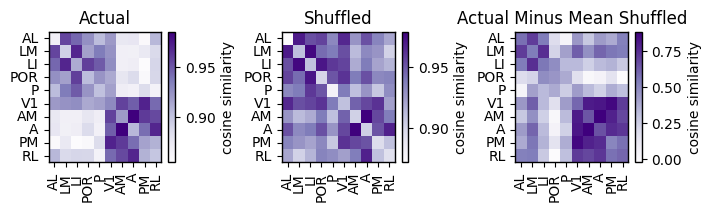

In [9]:
import itertools
fig, axs = plt.subplots(1, 3, figsize=(7, 2), constrained_layout = True)
which_ones = [cond_prob_dict, shuff_cond_prob_dict, mouse_cond_prob_minus_shuff]
#dict_to_look = mouse_cond_prob_minus_shuff
title = ['Actual', 'Shuffled', 'Actual Minus Mean Shuffled']
cosine_dict = {}
for i, dict_to_look in enumerate(which_ones):
    for mouse in mice:
        cosine_dict[mouse] = fpf.get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols = cols)
    #now for every value, get the cosine sim to itself
    to_itself_cosine = {}
    for area in cols:
        area_list = []
        for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
            neurons_1 = dict_to_look[mouse_a].loc[area]
            neurons_2 = dict_to_look[mouse_b].loc[area]
            neurons_1 =neurons_1.drop([area])
            neurons_2 =neurons_2.drop([area])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            area_list.append(cosine_similarity(bl, bl_2))
        to_itself_cosine[area] = np.mean(area_list)
    cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
    cosine_df= cosine_df.loc[cols][cols]
    for col in cols:
        cosine_df.loc[col, col] = to_itself_cosine[col]
    sb.heatmap(ax=axs[i], data=fpf.convert_matrix_names(cosine_df), cmap='Purples', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine similarity'}) 
    axs[i].set_title(f'{title[i]}')
    axs[i].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=10)
    for _, spine in axs[i].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

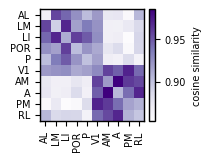

In [10]:
plt.figure(figsize=(2, 1.5), constrained_layout=True)

dict_to_look = cond_prob_dict  # Only use the first dictionary
title = 'Actual'

cosine_dict = {}
for mouse in mice:
    cosine_dict[mouse] = fpf.get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols=cols)

# Calculate cosine similarity to itself
to_itself_cosine = {}
for area in cols:
    area_list = []
    for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
        neurons_1 = dict_to_look[mouse_a].loc[area].drop([area])
        neurons_2 = dict_to_look[mouse_b].loc[area].drop([area])
        bl = np.array(neurons_1).reshape(1, -1)
        bl_2 = np.array(neurons_2).reshape(1, -1)
        area_list.append(cosine_similarity(bl, bl_2))
    to_itself_cosine[area] = np.mean(area_list)

cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
cosine_df = cosine_df.loc[cols][cols]
for col in cols:
    cosine_df.loc[col, col] = to_itself_cosine[col]

sb.heatmap(
    data=fpf.convert_matrix_names(cosine_df),
    cmap='Purples',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'cosine similarity'}
)


plt.tick_params(axis='y', which='major', labelsize=7, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=7, rotation=90)
ax = plt.gca()  # Get the current axis for further adjustments
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('cosine similarity', fontsize=7)

plt.show()


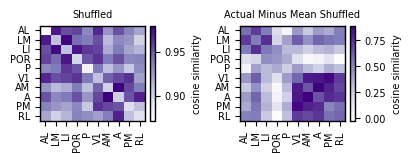

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(4, 1.5), constrained_layout=True)

which_ones = [shuff_cond_prob_dict, mouse_cond_prob_minus_shuff]
titles = ['Shuffled', 'Actual Minus Mean Shuffled']

for i, (dict_to_look, title) in enumerate(zip(which_ones, titles)):
    cosine_dict = {}
    for mouse in mice:
        cosine_dict[mouse] = fpf.get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols=cols)

    # Calculate cosine similarity to itself
    to_itself_cosine = {}
    for area in cols:
        area_list = []
        for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
            neurons_1 = dict_to_look[mouse_a].loc[area].drop([area])
            neurons_2 = dict_to_look[mouse_b].loc[area].drop([area])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            area_list.append(cosine_similarity(bl, bl_2))
        to_itself_cosine[area] = np.mean(area_list)

    cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
    cosine_df = cosine_df.loc[cols][cols]
    for col in cols:
        cosine_df.loc[col, col] = to_itself_cosine[col]

    sb.heatmap(
        ax=axs[i],
        data=fpf.convert_matrix_names(cosine_df),
        cmap='Purples',
        xticklabels=True,
        yticklabels=True,
        cbar_kws={'label': 'cosine similarity'}
    )
    axs[i].set_title(title, size=7)
    axs[i].tick_params(axis='y', which='major', labelsize=7, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=7)

    for _, spine in axs[i].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label('cosine similarity', fontsize=7)

plt.show()


In [12]:
#NB. this is only needed when plus 1million shuffles are generated and intermediate collate files are made.
# base_files = {
#     '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated.pkl': 'numbers_combined.pkl',
#     '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_cubelet_2_comb__collated.pkl': 'combinations_combined.pkl',
#     '/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_cubelet__collated.pkl': 'total_pop_combined.pkl'
# }
# dict_concat={}
# which_title= ['number', 'comb', 'total']
# i=0
# for base_path, output_name in base_files.items():
#     base_dir = os.path.dirname(base_path)
#     base_filename = os.path.basename(base_path).replace('.pkl', '')
#     file_pattern = os.path.join(base_dir, f'{base_filename}*.pkl')
#     matching_files = glob.glob(file_pattern)
#     data_frames = []
#     for file_path in matching_files:
#         try:
#             df = pd.read_pickle(file_path)
#             data_frames.append(df)
#             print(f"Loaded {file_path}")
#         except Exception as e:
#             print(f"Error loading {file_path}: {e}")
#     if data_frames:
#         concatenated_df = pd.concat(data_frames, ignore_index=True)
#         dict_concat[which_title[i]] = concatenated_df
#         i = i+1
#         output_path = os.path.join(base_dir, output_name)
#         #concatenated_df.to_pickle(output_path)
#         print(f"Concatenated DataFrame saved to {output_path}")
#     else:
#         print(f"No files matched for base path {base_path}.")

Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated_2.pkl
Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated_3.pkl
Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated_1.pkl
Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated.pkl
Concatenated DataFrame saved to /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/numbers_combined.pkl
Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_cubelet_2_comb__collated_2.pkl
Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_cubelet_2_comb__collated.pkl
Loaded /camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shu

In [13]:
shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/numbers_combined.pkl')
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/combinations_combined.pkl')
shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_pop_combined.pkl')
    

In [14]:
#likely no longer required - was necessary for concatenated shuffles when large numbers (+1mil) used and sometimes different column orders were made
combinations_df = pd.DataFrame()
all_cols = [col for col in dict_concat[which_title[0]].columns if col in all_combined['homogenous_across_cubelet']]
for first, second in itertools.combinations(all_cols, 2):
    if f'{first}, {second}' in dict_concat[which_title[1]].columns:
        combinations_df[f'{first}, {second}'] = dict_concat[which_title[1]][f'{first}, {second}']
        if f'{second}, {first}' in dict_concat[which_title[1]].columns:
            combinations_df.loc[dict_concat[which_title[1]][f'{first}, {second}'].isna(), f'{first}, {second}'] = dict_concat[which_title[1]][f'{second}, {first}']



In [ ]:
# import pandas as pd
# import numpy as np
# import itertools

# analysis_names = ['homogenous_across_cubelet']
# odds_dict = {}

# for analysis_num, analysis_type in enumerate(analysis_names):
#     which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
#     which = which_type[0]

#     # Load data efficiently
#     shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
#     shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
#     shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    
#     barcodes = all_combined[analysis_type]
#     all_cols = barcodes.columns

#     # Efficient column reordering
#     cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#     cols = [col for col in cols if col in all_cols]
#     cols_reordered = [col for col in cols if col in all_cols] + [col for col in all_cols if col not in cols if col != 'AUDp']

#     total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
#     odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'log_OR_actual', 'mean_shuf', 'mean_shuf_subtracted', 'p_value'])  

#     # Precompute proportions for efficiency
#     barcode_props = barcodes.astype(bool).sum() / len(barcodes)

#     # Iterate over unique pairs to avoid redundancies
#     for col, col_2 in itertools.combinations(cols_reordered, 2):
#         prob_df = barcodes[[col, col_2]].astype(bool)
#         probs_actual = (prob_df[col] & prob_df[col_2]).sum() / len(barcodes)
#         probs_joint = barcode_props[col] * barcode_props[col_2]

#         # Determine correct column name for shuffled data
#         column_name = f'{col}, {col_2}' if f'{col}, {col_2}' in shuffled_2_combinations.columns else f'{col_2}, {col}'
        
#         shuff_actual_prob = shuffled_2_combinations[column_name] / shuffle_total_numbers[0]
#         shuff_joint_prob = (shuffled_numbers[col] / shuffle_total_numbers[0]) * (shuffled_numbers[col_2] / shuffle_total_numbers[0])
#         shuff_odds_actual = shuff_actual_prob / (1 - shuff_actual_prob)
#         shuff_odds_joint = shuff_joint_prob / (1 - shuff_joint_prob)
#         shuff_log_odds = np.log2(shuff_odds_actual / shuff_odds_joint)
#         mean_shuff_log_odds = shuff_log_odds.mean()

#         actual_odds = probs_actual / (1 - probs_actual)
#         joint_odds = probs_joint / (1 - probs_joint)
#         OR_actual = actual_odds / joint_odds

#         # Calculate log odds and p-value
#         odds.loc['probs_actual', column_name] = probs_actual
#         odds.loc['probs_joint', column_name] = probs_joint
#         odds.loc['odds_actual', column_name] = actual_odds
#         odds.loc['odds_joint', column_name] = joint_odds
#         odds.loc['mean_shuf', column_name] = mean_shuff_log_odds
#         odds.loc['mean_shuf_subtracted', column_name] = np.log2(OR_actual) - mean_shuff_log_odds
#         odds.loc['log_OR_actual', column_name] = np.log2(OR_actual)

#         if OR_actual >= shuff_log_odds.mean():
#             p_val = ((shuff_log_odds > np.log2(OR_actual)).sum() + 1) / (len(shuff_log_odds) + 1) * 2
#         else:
#             p_val = ((shuff_log_odds < np.log2(OR_actual)).sum() + 1) / (len(shuff_log_odds) + 1) * 2

#         p_val_adj = p_val * total_combinations
#         odds.loc['p_value', column_name] = p_val_adj


In [15]:
# #analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
# analysis_names =['homogenous_across_cubelet']
# odds_dict = {}
# for analysis_num, analysis_type in enumerate(analysis_names):
#     which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
#     which = which_type[0]
#     shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/numbers_combined.pkl')
#     shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/combinations_combined.pkl')
#     shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_pop_combined.pkl')
#     barcodes = all_combined[analysis_type]
#     total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
#     all_cols = barcodes.columns
#     cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
#     cols_reordered = [item for item in cols_reordered if item != 'AUDp']
#     cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#     cols = [col for col in cols if col in all_cols]
#     odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'log_OR_actual', 'mean_shuf', 'mean_shuf_subtracted', 'p_value'])  
#     for column_name in shuffled_2_combinations.columns:
#         col, col_2= map(str.strip, column_name.split(','))
#     # for col in cols_reordered:
#     #     for col_2 in cols_reordered:
#     #         if col != col_2:
#         prob_df = pd.DataFrame()
#         prob_df["a"] = barcodes[col].astype(bool)
#         prob_df["b"] = barcodes[col_2].astype(bool)
#         prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
#         probs_actual = prob_df["matching"].sum() / len(barcodes)
#         probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
#         odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
#         odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
#         if f'{col}, {col_2}' in shuffled_2_combinations.columns:
#             column_name = f'{col}, {col_2}'
#         elif f'{col_2}, {col}' in shuffled_2_combinations.columns:
#             column_name = f'{col_2}, {col}'
#         shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers
#         shuff_joint_prob = (shuffled_numbers[col]/shuffle_total_numbers) * (shuffled_numbers[col_2]/shuffle_total_numbers)
#         shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
#         shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
#         oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
#         shuff_log_odds = np.log2(oddd)
#         mean_shuff_log_odds = shuff_log_odds.mean()
#         actual_odds = (probs_actual) / (1 - (probs_actual))
#         joint_odds = (probs_joint) / (1 - (probs_joint))
#         OR_actual = actual_odds/joint_odds
#         odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
#         odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
#         odds.loc['mean_shuf', f'{col}, {col_2}'] = mean_shuff_log_odds
#         odds.loc['mean_shuf_subtracted', f'{col}, {col_2}'] = np.log2(OR_actual - oddd.mean())
#         odds.loc['log_OR_actual', f'{col}, {col_2}'] = np.log2(OR_actual)
#         if OR_actual >= oddd.mean():
#             p_val = ((sum(1 for value in oddd if value > OR_actual)+1)/(len(oddd)+1))*2
#         elif OR_actual < mean_corr:
#             p_val = ((sum(1 for value in oddd if value < OR_actual)+1)/(len(oddd)+1))*2 
#         p_val_adj = p_val* total_combinations
#         odds.loc['p_value', f'{col}, {col_2}'] = p_val_adj
# to_plot = odds.T
# to_plot['-log10_p_value'] = -np.log10(to_plot['p_value'])
# to_plot['shuf-sub'] = to_plot['log_OR_actual'] -to_plot['mean_shuf']

In [ ]:

odds_dict = {}

barcodes = all_combined['homogenous_across_cubelet']
total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
all_cols = barcodes.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in all_cols]
odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'log_OR_actual', 'mean_shuf', 'mean_shuf_subtracted', 'p_value'])  
for column_name in shuffled_2_combinations.columns:
    col, col_2= map(str.strip, column_name.split(','))
# for col in cols_reordered:
#     for col_2 in cols_reordered:
#         if col != col_2:
    prob_df = pd.DataFrame()
    prob_df["a"] = barcodes[col].astype(bool)
    prob_df["b"] = barcodes[col_2].astype(bool)
    prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
    probs_actual = prob_df["matching"].sum() / len(barcodes)
    probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
    odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
    odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
    if f'{col}, {col_2}' in shuffled_2_combinations.columns:
        column_name = f'{col}, {col_2}'
    elif f'{col_2}, {col}' in shuffled_2_combinations.columns:
        column_name = f'{col_2}, {col}'
    shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers
    shuff_joint_prob = (shuffled_numbers[col]/shuffle_total_numbers) * (shuffled_numbers[col_2]/shuffle_total_numbers)
    shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
    shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
    oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
    shuff_log_odds = np.log2(oddd)
    mean_shuff_log_odds = shuff_log_odds.mean()
    actual_odds = (probs_actual) / (1 - (probs_actual))
    joint_odds = (probs_joint) / (1 - (probs_joint))
    OR_actual = actual_odds/joint_odds
    odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
    odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
    odds.loc['mean_shuf', f'{col}, {col_2}'] = mean_shuff_log_odds
    odds.loc['mean_shuf_subtracted', f'{col}, {col_2}'] = np.log2(OR_actual - oddd.mean())
    odds.loc['log_OR_actual', f'{col}, {col_2}'] = np.log2(OR_actual)
    if OR_actual >= oddd.mean():
        p_val = ((sum(1 for value in oddd if value > OR_actual)+1)/(len(oddd)+1))*2
    elif OR_actual < mean_corr:
        p_val = ((sum(1 for value in oddd if value < OR_actual)+1)/(len(oddd)+1))*2 
    p_val_adj = p_val* total_combinations
    odds.loc['p_value', f'{col}, {col_2}'] = p_val_adj
to_plot = odds.T
to_plot['-log10_p_value'] = -np.log10(to_plot['p_value'])
to_plot['shuf-sub'] = to_plot['log_OR_actual'] -to_plot['mean_shuf']

In [18]:
to_plot = odds.T
to_plot['-log10_p_value'] = -np.log10(to_plot['p_value'])
to_plot['shuf-sub'] = to_plot['log_OR_actual'] -to_plot['mean_shuf']

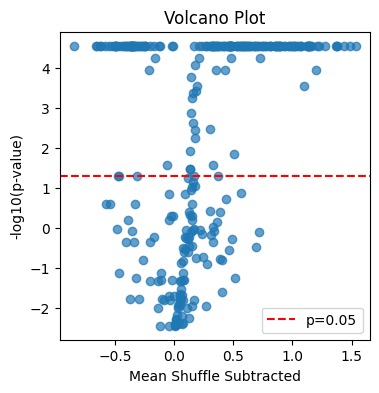

In [19]:
#['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
dorsal_stream = ['VISa', 'VISam', 'VISpm', 'VISrl']
ventral_stream = ['VISpor', 'VISpl', 'VISl', 'VISli', 'VISal']
# Create volcano plot
plt.figure(figsize=(4, 4))
plt.scatter(to_plot['shuf-sub'], to_plot['-log10_p_value'], alpha=0.7)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.xlabel('Mean Shuffle Subtracted')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')
plt.grid(False)
plt.legend()
plt.show()

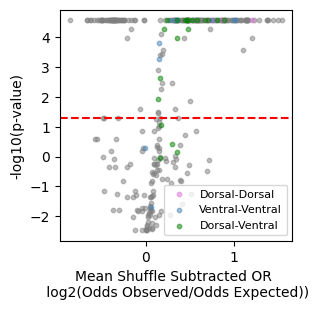

In [27]:
def classify_stream(pair):
    regions = pair.split(', ')
    is_dorsal = [region in dorsal_stream for region in regions]
    is_ventral = [region in ventral_stream for region in regions]
    
    if all(is_dorsal):
        return 'dorsal'
    elif all(is_ventral):
        return 'ventral'
    elif any(is_dorsal) and any(is_ventral):
        return 'dorsal-ventral'
    else:
        return 'other'

dot_size = 10
alpha_val = 0.5
to_plot['stream'] = to_plot.index.map(classify_stream)

plt.figure(figsize=(3, 3))

plt.scatter(
    to_plot[to_plot['stream'] == 'other']['shuf-sub'],
    to_plot[to_plot['stream'] == 'other']['-log10_p_value'],
    color='grey', s=dot_size, alpha=alpha_val)

plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal']['-log10_p_value'],
    color='orchid', alpha=alpha_val, s=dot_size, label='Dorsal-Dorsal'
)

# Plot ventral stream in blue
plt.scatter(
    to_plot[to_plot['stream'] == 'ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'ventral']['-log10_p_value'],
    color='steelblue', alpha=alpha_val, s=dot_size, label='Ventral-Ventral'
)

# Plot dorsal-ventral stream in green
plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal-ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal-ventral']['-log10_p_value'],
    color='green', alpha=alpha_val, s=dot_size, label='Dorsal-Ventral'
)

# Add a horizontal significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')#, label='p=0.05')

# Labels and title
plt.xlabel('Mean Shuffle Subtracted OR \n log2(Odds Observed/Odds Expected))')
plt.ylabel('-log10(p-value)')

plt.legend(loc='lower right', prop={'size': 8})
plt.show()

In [28]:
#analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
from scipy.stats import norm

barcodes = all_combined['homogenous_across_cubelet']
total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
all_cols = barcodes.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in all_cols]
odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'log_OR_actual', 'mean_shuf', 'mean_shuf_subtracted', 'p_value'])  
for column_name in shuffled_2_combinations.columns:
    if any(substring in column_name for substring in cols):
        col, col_2= map(str.strip, column_name.split(','))
# for col in cols_reordered:
#     for col_2 in cols_reordered:
#         if col != col_2:
        prob_df = pd.DataFrame()
        prob_df["a"] = barcodes[col].astype(bool)
        prob_df["b"] = barcodes[col_2].astype(bool)
        prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
        probs_actual = prob_df["matching"].sum() / len(barcodes)
        probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
        odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
        odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
        if f'{col}, {col_2}' in shuffled_2_combinations.columns:
            column_name = f'{col}, {col_2}'
        elif f'{col_2}, {col}' in shuffled_2_combinations.columns:
            column_name = f'{col_2}, {col}'
        shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers
        shuff_joint_prob = (shuffled_numbers[col]/shuffle_total_numbers) * (shuffled_numbers[col_2]/shuffle_total_numbers)
        shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
        shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
        oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
        shuff_log_odds = np.log2(oddd)
        mean_shuff_log_odds = shuff_log_odds.mean()
        actual_odds = (probs_actual) / (1 - (probs_actual))
        joint_odds = (probs_joint) / (1 - (probs_joint))
        OR_actual = actual_odds/joint_odds
        odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
        odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
        odds.loc['mean_shuf', f'{col}, {col_2}'] = mean_shuff_log_odds
        odds.loc['mean_shuf_subtracted', f'{col}, {col_2}'] = np.log2(OR_actual - oddd.mean())
        odds.loc['log_OR_actual', f'{col}, {col_2}'] = np.log2(OR_actual)
        mu, std = norm.fit(oddd)
        if OR_actual >= oddd.mean():
            p_val = norm.sf(OR_actual, loc=mu, scale=std) * 2  # two-sided
        else:
            p_val = norm.cdf(OR_actual, loc=mu, scale=std) * 2
        # if OR_actual >= oddd.mean():
        #     p_val = ((sum(1 for value in oddd if value > OR_actual)+1)/(len(oddd)+1))*2
        # elif val_to_comp < mean_corr:
        #     p_val = ((sum(1 for value in oddd if value < OR_actual)+1)/(len(oddd)+1))*2 
        p_val_adj = p_val* total_combinations
        odds.loc['p_value', f'{col}, {col_2}'] = p_val_adj
to_plot = odds.T
to_plot['-log10_p_value'] = -np.log10(to_plot['p_value'])
to_plot['shuf-sub'] = to_plot['log_OR_actual'] -to_plot['mean_shuf']


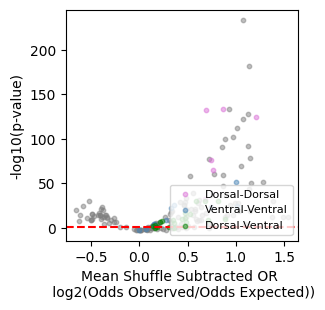

In [29]:
def classify_stream(pair):
    regions = pair.split(', ')
    is_dorsal = [region in dorsal_stream for region in regions]
    is_ventral = [region in ventral_stream for region in regions]
    
    if all(is_dorsal):
        return 'dorsal'
    elif all(is_ventral):
        return 'ventral'
    elif any(is_dorsal) and any(is_ventral):
        return 'dorsal-ventral'
    else:
        return 'other'

dot_size = 10
alpha_val = 0.5
to_plot['stream'] = to_plot.index.map(classify_stream)

plt.figure(figsize=(3, 3))

plt.scatter(
    to_plot[to_plot['stream'] == 'other']['shuf-sub'],
    to_plot[to_plot['stream'] == 'other']['-log10_p_value'],
    color='grey', s=dot_size, alpha=alpha_val)

plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal']['-log10_p_value'],
    color='orchid', alpha=alpha_val, s=dot_size, label='Dorsal-Dorsal'
)

# Plot ventral stream in blue
plt.scatter(
    to_plot[to_plot['stream'] == 'ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'ventral']['-log10_p_value'],
    color='steelblue', alpha=alpha_val, s=dot_size, label='Ventral-Ventral'
)

# Plot dorsal-ventral stream in green
plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal-ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal-ventral']['-log10_p_value'],
    color='green', alpha=alpha_val, s=dot_size, label='Dorsal-Ventral'
)

# Add a horizontal significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')#, label='p=0.05')

# Labels and title
plt.xlabel('Mean Shuffle Subtracted OR \n log2(Odds Observed/Odds Expected))')
plt.ylabel('-log10(p-value)')

plt.legend(loc='lower right', prop={'size': 8})
plt.show()

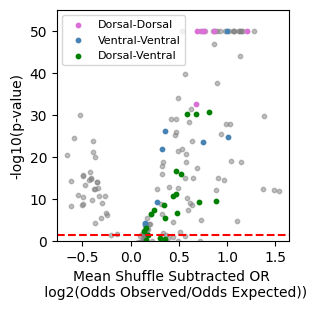

In [39]:
# Cap the y-axis values at 50
alpha_val_stream = 1
to_plot['-log10_p_value'] = to_plot['-log10_p_value'].clip(upper=50)

plt.figure(figsize=(3, 3))

# Plot 'other' stream
plt.scatter(
    to_plot[to_plot['stream'] == 'other']['shuf-sub'],
    to_plot[to_plot['stream'] == 'other']['-log10_p_value'],
    color='grey', s=dot_size, alpha=alpha_val)

# Plot 'dorsal' stream
plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal']['-log10_p_value'],
    color='orchid', alpha=alpha_val_stream, s=dot_size, label='Dorsal-Dorsal'
)

# Plot 'ventral' stream
plt.scatter(
    to_plot[to_plot['stream'] == 'ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'ventral']['-log10_p_value'],
    color='steelblue', alpha=alpha_val_stream, s=dot_size, label='Ventral-Ventral'
)

# Plot 'dorsal-ventral' stream
plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal-ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal-ventral']['-log10_p_value'],
    color='green', alpha=alpha_val_stream, s=dot_size, label='Dorsal-Ventral'
)

# Add a horizontal significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # Horizontal line at p=0.05

# Labels and title
plt.xlabel('Mean Shuffle Subtracted OR \n log2(Odds Observed/Odds Expected))')
plt.ylabel('-log10(p-value)')

# Limit y-axis to 50
plt.ylim(0, 55)

plt.legend(loc='upper left', prop={'size': 8})
plt.show()


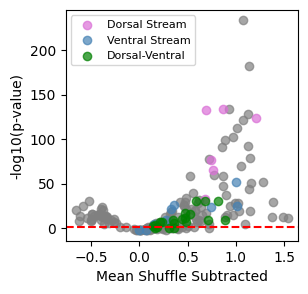

In [187]:
def classify_stream(pair):
    regions = pair.split(', ')
    is_dorsal = [region in dorsal_stream for region in regions]
    is_ventral = [region in ventral_stream for region in regions]
    
    if all(is_dorsal):
        return 'dorsal'
    elif all(is_ventral):
        return 'ventral'
    elif any(is_dorsal) and any(is_ventral):
        return 'dorsal-ventral'
    else:
        return 'other'

to_plot['stream'] = to_plot.index.map(classify_stream)

plt.figure(figsize=(3, 3))

plt.scatter(
    to_plot[to_plot['stream'] == 'other']['shuf-sub'],
    to_plot[to_plot['stream'] == 'other']['-log10_p_value'],
    color='grey', alpha=0.7)

plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal']['-log10_p_value'],
    color='orchid', alpha=0.7, label='Dorsal Stream'
)

# Plot ventral stream in blue
plt.scatter(
    to_plot[to_plot['stream'] == 'ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'ventral']['-log10_p_value'],
    color='steelblue', alpha=0.7, label='Ventral Stream'
)

# Plot dorsal-ventral stream in green
plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal-ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal-ventral']['-log10_p_value'],
    color='green', alpha=0.7, label='Dorsal-Ventral'
)

# Add a horizontal significance threshold line
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')#, label='p=0.05')

# Labels and title
plt.xlabel('Mean Shuffle Subtracted')
plt.ylabel('-log10(p-value)')

plt.legend(loc='upper left', prop={'size': 8})
plt.show()

In [123]:
from scipy.stats import genextreme  
def fit_evt_and_compute_pvalue(oddd, OR_actual):
    flattened = oddd.values.flatten()
    try:
        # Fit the Generalized Extreme Value (GEV) distribution
        shape, loc, scale = genextreme.fit(flattened)
        # Compute the p-value as the survival function
        p_value = genextreme.sf(OR_actual, shape, loc=loc, scale=scale)
        return {"p_value": p_value, "GEV_params": {"shape": shape, "loc": loc, "scale": scale}}
    except Exception as e:
        return {"error": f"GEV fitting failed: {e}"}

# Example usage
results_evt = fit_evt_and_compute_pvalue(oddd, OR_actual)
if "p_value" in results_evt:
    print(f"P-value (EVT): {results_evt['p_value']}")
    print(f"GEV Parameters: {results_evt['GEV_params']}")
else:
    print(results_evt["error"])

KeyboardInterrupt: 

In [181]:
from scipy.stats import norm
#analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
analysis_names =['homogenous_across_cubelet']
odds_dict = {}
for analysis_num, analysis_type in enumerate(analysis_names):
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
    which = which_type[0]
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
    shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    barcodes = all_combined[analysis_type]
    total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
    odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'actual_vs_joint', 'mean_shuf', 'p_value'])  
    all_cols = barcodes.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in all_cols]
    for col in cols_reordered:
        for col_2 in cols_reordered:
            if col != col_2:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
                odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
                if f'{col}, {col_2}' in shuffled_2_combinations.columns:
                    column_name = f'{col}, {col_2}'
                elif f'{col_2}, {col}' in shuffled_2_combinations.columns:
                    column_name = f'{col_2}, {col}'
                shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
                shuff_joint_prob = (shuffled_numbers[col]/shuffle_total_numbers[0]) * (shuffled_numbers[col_2]/shuffle_total_numbers[0])
    
    
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            #if separated_words[0] in cols or separated_words[1] in cols:
            shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
            shuff_joint_prob = (shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * (shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0])
            probabilities = pd.concat([shuff_actual_prob, shuff_joint_prob])
            non_zero_probabilities = probabilities[probabilities>0]
            
    adjustment =  min(smallest_probs) * 0.1  
    for col in cols_reordered:
        for col_2 in cols_reordered:
            if col != col_2:
                probs_actual = odds.loc['probs_actual', f'{col}, {col_2}']
                probs_joint = odds.loc['probs_joint', f'{col}, {col_2}']
                actual_odds = (probs_actual + adjustment) / (1 - (probs_actual + adjustment))
                joint_odds = (probs_joint + adjustment) / (1 - (probs_joint + adjustment))
                odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
                odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
                odds.loc['actual_vs_joint', f'{col}, {col_2}'] = np.log2(actual_odds / joint_odds)
    
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            #if separated_words[0] in cols or separated_words[1] in cols:
            shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
            shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
            shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
            shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
            oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
            
            shuff_log_odds = np.log2(oddd)
            mean_shuff_log_odds = shuff_log_odds.mean()
            if column_name in odds.columns:
                col = separated_words[0]
                col_2 = separated_words[1]
            else:
                col = separated_words[1]
                col_2 = separated_words[0]
            val_to_comp = odds.loc['actual_vs_joint', f'{col}, {col_2}']
            #subtract_shuff = (odds.loc['odds_actual', f'{col}, {col_2}']/odds.loc['odds_joint', f'{col}, {col_2}']) - (oddd.mean())
            subtract_shuff = val_to_comp - mean_shuff_log_odds
            mu, std = norm.fit(shuff_log_odds)

            # Calculate the p-value based on the fitted distribution
            if val_to_comp >= mean_shuff_log_odds:
                p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
            else:
                p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
            # if val_to_comp >= mean_shuff_log_odds:
            #     p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
            # else:
            #     p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
            if p_val == 0:
                print(col, col_2)
            #adj_pval= p_val*(len(cols_reordered)*(len(cols_reordered)-1))
            odds.loc['p_value', f'{col}, {col_2}'] = p_val

            odds.loc['mean_shuf', f'{col}, {col_2}'] = subtract_shuff
            # if col in cols and col_2 in cols:
            odds.loc['p_value', f'{col_2}, {col}'] = p_val
            odds.loc['mean_shuf', f'{col_2}, {col}'] = subtract_shuff
    odds_dict[analysis_type] = odds
                

KeyboardInterrupt: 

In [36]:
(shuffled_numbers[col]/shuffle_total_numbers[0]) * (shuffled_numbers[col_2]/shuffle_total_numbers[0])

0     0.011314
1      0.01068
2     0.010917
3     0.010887
4      0.01087
        ...   
95    0.011005
96    0.011055
97    0.010907
98    0.010709
99    0.010609
Length: 100000, dtype: object

In [39]:
(shuffled_numbers[col]/shuffle_total_numbers[0])

0     0.087778
1     0.084815
2     0.087593
3     0.087222
4     0.087222
        ...   
95    0.087778
96    0.087407
97    0.086111
98    0.085926
99       0.085
Length: 100000, dtype: object

In [40]:
(shuffled_numbers[col_2]/shuffle_total_numbers[0])

0     0.128889
1     0.125926
2      0.12463
3     0.124815
4      0.12463
        ...   
95     0.12537
96    0.126481
97    0.126667
98     0.12463
99    0.124815
Length: 100000, dtype: object

In [5]:
#alternative way to estimate pvalue so that no zeros    
from scipy.stats import norm
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
odds_dict = {}
for analysis_num, analysis_type in enumerate(analysis_names):
    smallest_probs = []
    barcodes = all_combined[analysis_type]
    odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'actual_vs_joint', 'mean_shuf', 'p_value'])  
    all_cols = barcodes.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in all_cols]
    for col in cols_reordered:
        for col_2 in cols_reordered:
            if col != col_2:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
                odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
    which = which_type[0]
    smallest_prob = odds.loc[['probs_actual', 'probs_joint']][odds > 0].min().min()  # Find the smallest non-zero probability
    smallest_probs.append(smallest_prob)
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
    shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            #if separated_words[0] in cols or separated_words[1] in cols:
            shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
            shuff_joint_prob = (shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * (shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0])
            probabilities = pd.concat([shuff_actual_prob, shuff_joint_prob])
            non_zero_probabilities = probabilities[probabilities>0]
            smallest_probs.append(non_zero_probabilities.min())
    adjustment =  min(smallest_probs) * 0.1  
    for col in cols_reordered:
        for col_2 in cols_reordered:
            if col != col_2:
                probs_actual = odds.loc['probs_actual', f'{col}, {col_2}']
                probs_joint = odds.loc['probs_joint', f'{col}, {col_2}']
                actual_odds = (probs_actual + adjustment) / (1 - (probs_actual + adjustment))
                joint_odds = (probs_joint + adjustment) / (1 - (probs_joint + adjustment))
                odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
                odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
                odds.loc['actual_vs_joint', f'{col}, {col_2}'] = np.log2(actual_odds / joint_odds)
    
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            #if separated_words[0] in cols or separated_words[1] in cols:
            shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
            shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
            shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
            shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
            oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
            
            shuff_log_odds = np.log2(oddd)
            mean_shuff_log_odds = shuff_log_odds.mean()
            if column_name in odds.columns:
                col = separated_words[0]
                col_2 = separated_words[1]
            else:
                col = separated_words[1]
                col_2 = separated_words[0]
            val_to_comp = odds.loc['actual_vs_joint', f'{col}, {col_2}']
            #subtract_shuff = (odds.loc['odds_actual', f'{col}, {col_2}']/odds.loc['odds_joint', f'{col}, {col_2}']) - (oddd.mean())
            subtract_shuff = val_to_comp - mean_shuff_log_odds
            mu, std = norm.fit(shuff_log_odds)

            # Calculate the p-value based on the fitted distribution
            if val_to_comp >= mean_shuff_log_odds:
                p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
            else:
                p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
            # if val_to_comp >= mean_shuff_log_odds:
            #     p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
            # else:
            #     p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
            if p_val == 0:
                print(col, col_2)
            #adj_pval= p_val*(len(cols_reordered)*(len(cols_reordered)-1))
            odds.loc['p_value', f'{col}, {col_2}'] = p_val

            odds.loc['mean_shuf', f'{col}, {col_2}'] = subtract_shuff
            # if col in cols and col_2 in cols:
            odds.loc['p_value', f'{col_2}, {col}'] = p_val
            odds.loc['mean_shuf', f'{col_2}, {col}'] = subtract_shuff
    odds_dict[analysis_type] = odds
                

In [ ]:
from itertools import combinations
if val_to_comp >= mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                elif val_to_comp < mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2

In [17]:
shuffled_2_combinations['VISl, VISp']

0     141
1     132
2     140
3     144
4     130
     ... 
95    114
96    144
97    129
98    134
99    123
Name: VISl, VISp, Length: 100000, dtype: object

In [18]:
column_name = 'VISl, VISp'

(array([2.3000e+01, 3.7300e+02, 3.0570e+03, 1.2211e+04, 2.6685e+04,
        3.0713e+04, 1.9033e+04, 6.5180e+03, 1.2650e+03, 1.2200e+02]),
 array([92.0, 99.1, 106.2, 113.3, 120.4, 127.5, 134.6, 141.7, 148.8, 155.9,
        163.0], dtype=object),
 <BarContainer object of 10 artists>)

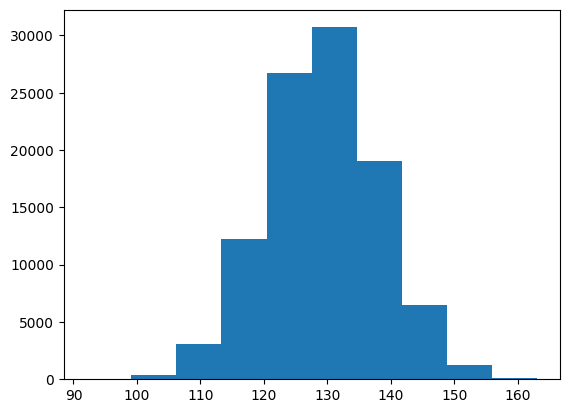

In [19]:
plt.hist(shuffled_2_combinations[column_name])

In [13]:
col = 'VISl'
col_2 = 'VISp'
prob_df = pd.DataFrame()
prob_df["a"] = barcodes[col].astype(bool)
prob_df["b"] = barcodes[col_2].astype(bool)
prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)

In [14]:
prob_df["matching"].sum()

193

In [12]:
odds

,"VISl, VISpor","VISl, VISp","VISl, VISam","VISl, VISa","VISl, VISpm","VISl, VISrl","VISl, RSPd","VISl, SSp","VISl, RSPagl","VISl, SSs",...,"MOs, RSPd","MOs, SSp","MOs, RSPagl","MOs, SSs","MOs, TEa","MOs, MOp","MOs, ACAv","MOs, AUDv","MOs, AUDpo","MOs, AUDd"
probs_actual,2.940053e-02,3.684612e-02,2.233677e-02,2.959145e-02,1.756396e-02,2.500955e-02,2.271859e-02,0.017946,0.003246,0.019091,...,0.005536,1.279114e-02,0.001527,0.010309,2.558228e-02,7.063765e-03,0.002100,0.015846,0.014891,0.013555
probs_joint,1.422495e-02,7.481272e-03,4.952391e-03,9.152140e-03,3.537422e-03,7.541484e-03,4.320171e-03,0.008113,0.001189,0.010371,...,0.001538,2.887853e-03,0.000423,0.003692,1.828617e-02,6.482936e-04,0.000150,0.012634,0.012510,0.010925
actual_vs_joint,1.069413e+00,2.342348e+00,2.196974e+00,1.722265e+00,2.329890e+00,1.754188e+00,2.419620e+00,1.158901,1.445788,0.892596,...,1.848987,2.158616e+00,1.834892,1.489414,4.949881e-01,3.440131e+00,3.745568,0.331349,0.254669,0.314881
mean_shuf,5.873517e-01,1.188234e+00,9.384276e-01,6.485149e-01,1.105542e+00,6.205610e-01,1.093833e+00,0.528155,1.313782,0.320977,...,1.409224,1.230643e+00,1.197163,0.840518,2.884963e-01,2.823333e+00,3.224750,-0.215076,-0.032207,-0.025279
p_value,1.889549e-09,4.103732e-31,7.448522e-12,2.883429e-12,1.598999e-10,3.976603e-08,2.000015e-14,0.000030,0.008510,0.007242,...,0.000030,3.238538e-11,0.165679,0.000015,2.123908e-07,4.519561e-07,0.076129,0.008897,0.704538,0.802135
odds_actual,3.029897e-02,3.826368e-02,2.285485e-02,3.050167e-02,1.788564e-02,2.565886e-02,2.325448e-02,0.018281,0.003264,0.019471,...,0.005575,1.296448e-02,0.001537,0.010424,2.626172e-02,7.121530e-03,0.002112,0.016109,0.015124,0.013749
odds_joint,1.443785e-02,7.545183e-03,4.984521e-03,9.244220e-03,3.557440e-03,7.606310e-03,4.346388e-03,0.008187,0.001198,0.010488,...,0.001547,2.903667e-03,0.000431,0.003713,1.863446e-02,6.561312e-04,0.000157,0.012803,0.012677,0.011053


In [8]:
col_2

'VISam'

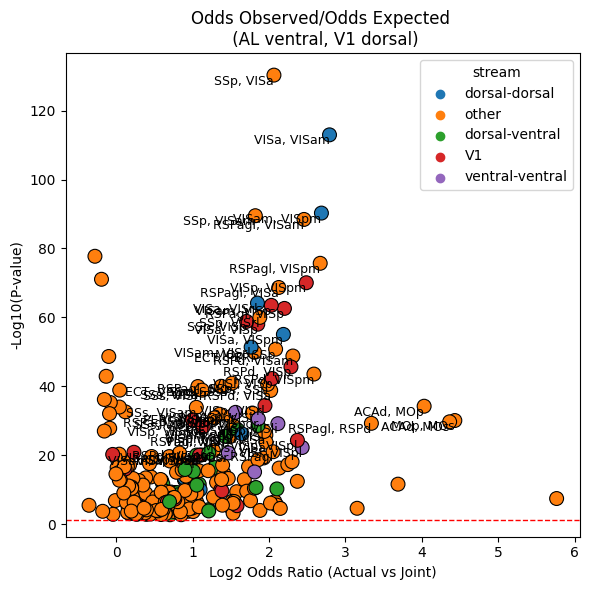

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `odds_dict`, `key`, and `odds_transposed` are already defined in your environment.
key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
new_columns = {}
for col in odds.columns:
    items = col.split(', ')
    sorted_col = ', '.join(sorted(items))
    new_columns[col] = sorted_col

# Rename columns in DataFrame
odds.rename(columns=new_columns, inplace=True)

# Drop duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = len(new_columns)
#odds.loc['p_value_corrected'] = odds.loc['p_value'] * number_of_tests
odds.loc['neg_log10_p_value'] = -np.log10(odds.loc['p_value'])
correction_factor_log = np.log10(number_of_tests)
odds.loc['neg_log10_p_value_corrected'] = odds.loc['neg_log10_p_value'] + correction_factor_log

ventral_stream = ['VISl', 'VISli', 'VISpor', 'VISpl']  
dorsal_stream = ['VISal', 'VISam', 'VISa', 'VISpm', 'VISrl', 'VISal']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']

for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if separated_words[0] in dorsal_stream and separated_words[1] in dorsal_stream:
        odds.loc['stream', column_name] = 'dorsal-dorsal'
    if separated_words[0] in ventral_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'ventral-ventral'
    if separated_words[0] in dorsal_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    if separated_words[1] in dorsal_stream and separated_words[0] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    elif separated_words[1] not in cols or separated_words[0] not in cols:
        if separated_words[1] =='VISp' or separated_words[0] =='VISp':
            odds.loc['stream', column_name] = 'V1'
        else:
            odds.loc['stream', column_name] = 'other'
            #odds.drop(columns=[column_name], inplace=True)
        
# Prepare data for plotting
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')

# Apply -log10 transformation
#odds_transposed['neg_log10_p_value'] = -np.log10(odds_transposed['p_value'])

# Filter significant points
p_value_cutoff = 20
significant = odds_transposed[
    (odds_transposed['neg_log10_p_value_corrected'] > p_value_cutoff) & (odds_transposed['actual_versus_joint'] > 1)
]

# First Plot: actual_versus_joint
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value_corrected', 
    edgecolor='k', hue='stream',
    s=100,
    ax=ax
)

ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
ax.set_title('Odds Observed/Odds Expected \n (AL ventral, V1 dorsal)')
ax.set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
ax.set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    ax.text(row['actual_versus_joint'], row['neg_log10_p_value'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()

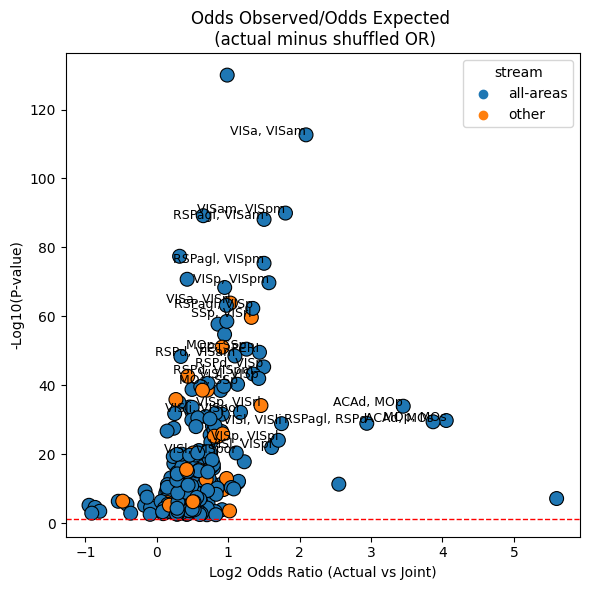

In [49]:

fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `odds_dict` and `key` are already defined
key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
odds.columns = [', '.join(sorted(col.split(', '))) for col in odds.columns]

# Remove duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = odds.shape[1]
odds.loc['neg_log10_p_value'] = -np.log10(odds.loc['p_value'])
correction_factor_log = np.log10(number_of_tests)
odds.loc['neg_log10_p_value_corrected'] = odds.loc['neg_log10_p_value'] + correction_factor_log

# Group all areas
all_areas = odds.columns.str.split(', ').str.get(0).unique()
cols = list(all_areas)

# Assign stream labels
for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if len(set(separated_words) - set(cols)) == 0:
        odds.loc['stream', column_name] = 'all-areas'
    else:
        odds.loc['stream', column_name] = 'other'

# Prepare data for plotting
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')
odds_transposed['mean_shuff_numeric'] = pd.to_numeric(odds_transposed['mean_shuf'], errors='coerce')
odds_transposed['actual_versus_joint'] = odds_transposed['actual_versus_joint'] - odds_transposed['mean_shuff_numeric']

# Filter significant points
p_value_cutoff = 20
significant = odds_transposed[
    (odds_transposed['neg_log10_p_value_corrected'] > p_value_cutoff) & (odds_transposed['actual_versus_joint'] > 1)
]

# Scatter plot
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value_corrected', 
    edgecolor='k', hue='stream',
    s=100,
    ax=ax
)

# Add horizontal significance line
ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)

# Customize plot
ax.set_title('Odds Observed/Odds Expected \n (actual minus shuffled OR)')
ax.set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
ax.set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    ax.text(row['actual_versus_joint'], row['neg_log10_p_value_corrected'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()


In [50]:
number_of_tests

276

In [52]:
odds_dict['homogenous_across_cubelet']

,"VISa, VISal","MOp, VISal","TEa, VISal","PERI, VISal","ACAd, VISal","SSp, VISal","RSPd, VISal","MOs, VISal","ACAv, VISal","ECT, VISal",...,"AUDd, VISrl","RSPagl, VISrl","AUDv, VISrl","VISl, VISrl","VISam, VISrl","VISli, VISrl","VISpl, VISrl","VISp, VISrl","VISpm, VISrl","VISpor, VISrl"
probs_actual,9.185185e-02,0.029074,0.394259,9.703704e-02,0.005926,1.312963e-01,0.054074,0.026852,0.003519,1.420370e-01,...,1.542593e-01,5.203704e-02,1.077778e-01,5.870370e-02,7.037037e-02,5.407407e-02,0.013704,9.203704e-02,4.407407e-02,0.064815
probs_joint,5.798772e-02,0.020549,0.343351,8.993505e-02,0.007571,8.535926e-02,0.030949,0.018470,0.002579,1.493371e-01,...,9.306821e-02,1.917212e-02,1.185402e-01,2.271368e-02,2.176019e-02,2.969465e-02,0.005959,2.560823e-02,1.450679e-02,0.040966
actual_vs_joint,7.162913e-01,0.513046,0.315882,1.209435e-01,-0.355293,6.954913e-01,0.839699,0.552011,0.448030,-8.462869e-02,...,8.297169e-01,1.489239e+00,-1.548138e-01,1.423646e+00,1.766367e+00,9.012341e-01,1.211298,1.947083e+00,1.646504e+00,0.698088
mean_shuf,1.821779e-01,0.170977,0.074609,-3.721236e-01,0.593769,2.950427e-01,0.153054,0.213509,0.618093,-3.218430e-01,...,3.189076e-01,6.400277e-01,-4.223815e-01,6.167917e-01,8.511545e-01,4.840623e-01,0.192356,4.882447e-01,7.235768e-01,0.191672
p_value,2.436897e-07,0.001065,0.006149,1.353334e-30,0.001725,1.275251e-17,0.000189,0.000070,0.001831,7.750102e-26,...,1.152744e-18,2.111303e-23,3.542516e-34,1.570271e-23,2.277810e-49,7.124373e-14,0.075405,2.002152e-32,3.351391e-24,0.000159
odds_actual,1.011537e-01,0.029955,0.650898,1.074770e-01,0.005971,1.511533e-01,0.057176,0.027603,0.003541,1.655646e-01,...,1.824090e-01,5.490430e-02,1.208092e-01,6.237566e-02,7.570841e-02,5.717604e-02,0.013904,1.013782e-01,4.611675e-02,0.069318
odds_joint,6.156819e-02,0.020991,0.522905,9.883435e-02,0.007638,9.333701e-02,0.031948,0.018827,0.002595,1.755672e-01,...,1.026305e-01,1.955693e-02,1.344942e-01,2.325171e-02,2.225433e-02,3.061368e-02,0.006005,2.629144e-02,1.473030e-02,0.042727


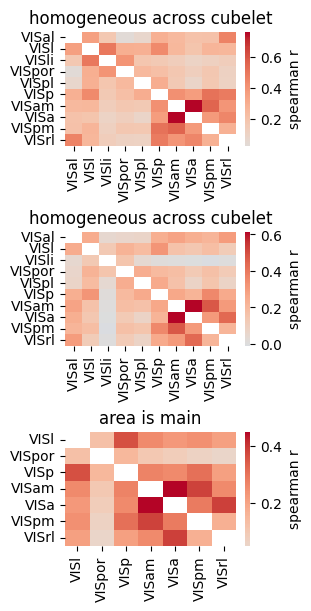

In [3]:
titles = ['homogeneous across cubelet', 'homogeneous across cubelet', 'area is main']
analysis_names = ['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 1, figsize=(3, 6), constrained_layout=True)
for number, matrix_key in enumerate(analysis_names):
    matrix= all_combined[matrix_key]
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    hvas = [col for col in cols if col in matrix.columns]
    correlation_vis = pd.DataFrame(index=hvas, columns=hvas)
    for area in hvas:
        for area2 in hvas:
            if area == area2:
                correlation_vis.loc[area, area2] = np.nan
            else:
                correlation_vis.loc[area, area2] = matrix[area].corr(matrix[area2], method='spearman')
    correlation_vis =correlation_vis.apply(pd.to_numeric, errors='coerce')
    sb.heatmap(
                ax=axs[number], 
                data=correlation_vis, 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'spearman r'}
            )
    axs[number].set_title(f'{titles[number]}')

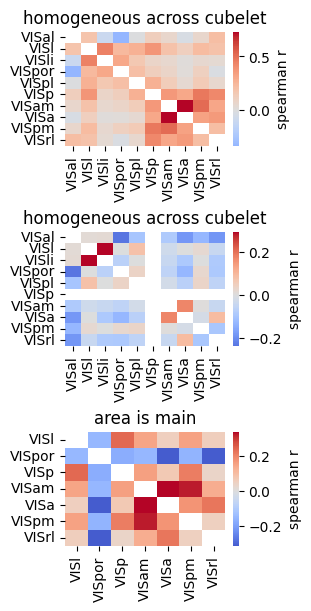

In [3]:
titles = ['homogeneous across cubelet', 'homogeneous across cubelet', 'area is main']
analysis_names = ['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 1, figsize=(3, 6), constrained_layout=True)
for number, matrix_key in enumerate(analysis_names):
    matrix= all_combined[matrix_key]
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    hvas = [col for col in cols if col in matrix.columns]
    matrix = matrix[matrix[hvas].sum(axis=1)>0]
    correlation_vis = pd.DataFrame(index=hvas, columns=hvas)
    for area in hvas:
        for area2 in hvas:
            if area == area2:
                correlation_vis.loc[area, area2] = np.nan
            else:
                correlation_vis.loc[area, area2] = matrix[area].corr(matrix[area2], method='spearman')
    correlation_vis =correlation_vis.apply(pd.to_numeric, errors='coerce')
    sb.heatmap(
                ax=axs[number], 
                data=correlation_vis, 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'spearman r'}
            )
    axs[number].set_title(f'{titles[number]}')

In [3]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob

In [4]:
def get_cond_prob_high_thresh(matrix, columns, index, mice, thresh=0.7):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                index_list = []
                for mouse in mice:
                    parameters_path = (
                    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
                    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
                    to_areas_with_thresh = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False, IT_only=True, area_threshold=thresh)
                if col in to_areas_with_thresh.columns:
                    index_list.extend(to_areas_with_thresh[to_areas_with_thresh[col]>0].index.to_list())
                conditional_prob.loc[col, area] = matrix.loc[index_list].astype(bool).astype(int)[area].mean()
    return conditional_prob


In [8]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
for key in analysis_names:
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy()
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    if 'shuff' in key:
        which = key.split('shuff_')[-1]
        #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        if which in ('cubelet', 'area'):
            matrix_to_comp = all_combined[f'homogenous_across_{which}']
        elif which == 'main':
            matrix_to_comp= all_combined['area_is_main']
        conditional_prob = get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
        shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
        mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for column_name in shuffled_cond_prob.columns:
            separated_words = column_name.split(', ')
            mean_corr = shuffled_cond_prob[column_name].mean()
            if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
                # if separated_words[1] in cols:
                #     mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
                val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
                if val_to_comp >= mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                elif val_to_comp < mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                # if separated_words[1] in cols_reordered:
                #     p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        np.fill_diagonal(mean_val_matrix.values, np.nan)
        np.fill_diagonal(p_val_matrix.values, np.nan)
        number_tests = len(cols)* (len(cols_reordered)-1)
        p_val_matrix = p_val_matrix*number_tests #bonferroni correction
        p_val_dict[key] =p_val_matrix
        conditional_probability_dict[key] =mean_val_matrix
    else:
       conditional_probability_dict[key] = get_cond_prob(matrix=all_combined[key][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    

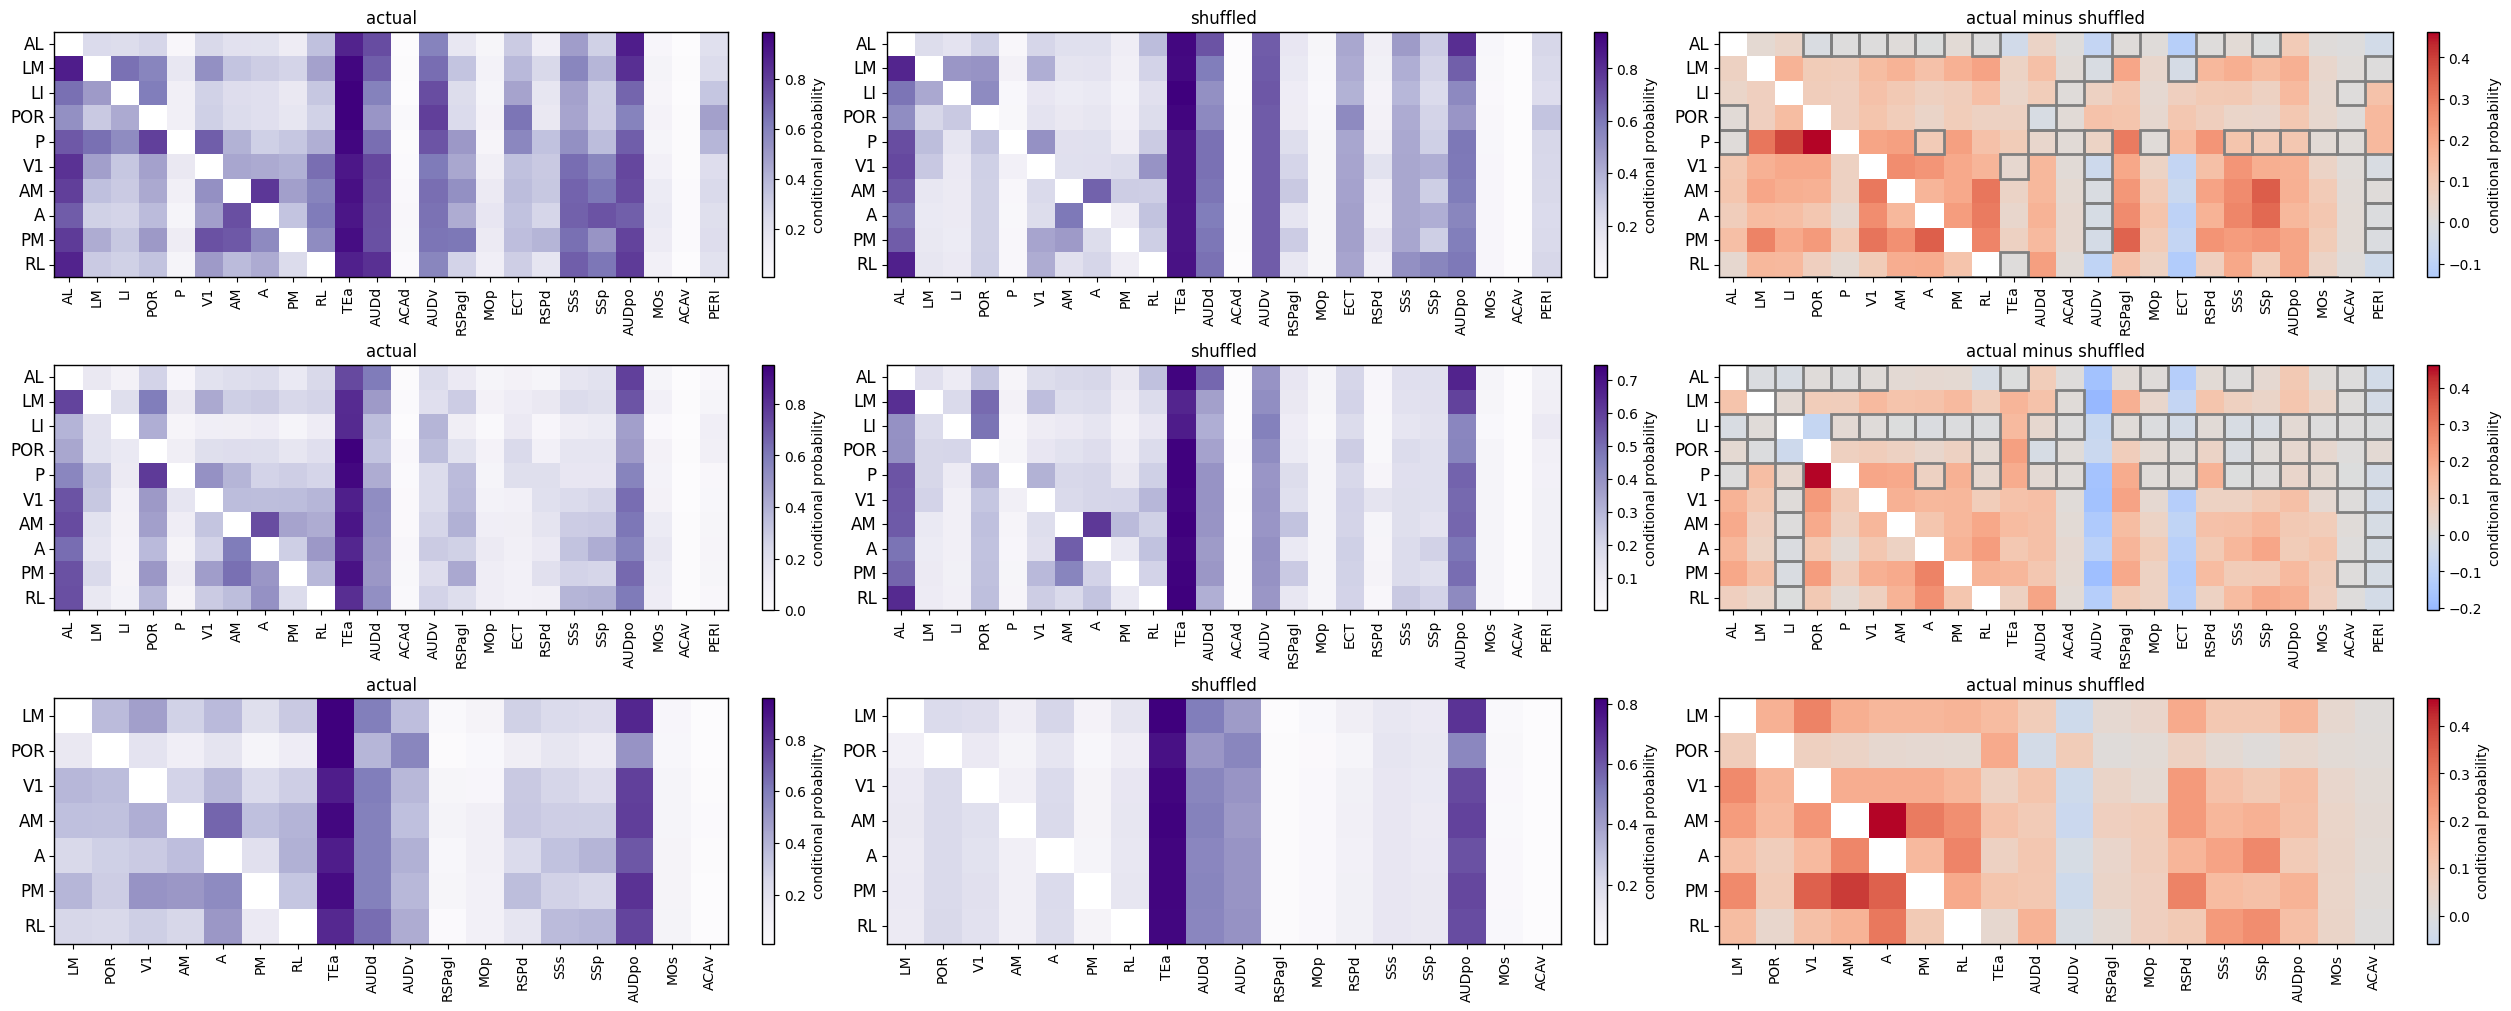

In [14]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(3, 3, figsize=(25, 10), constrained_layout=True)
cond_prob_dif_dict = {}
titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    cond_prob_dif_dict[analysis_type] = combined_dif
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        axs[analysis_num, number].set_title(f'{titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if analysis_type != 'main':
            if number>1:
                for ii in data_to_use.index:
                    for j in data_to_use.columns:
                        if p_val_dict[f'shuff_{analysis_type}'].loc[ii, j] > 0.05:
                            row_idx = data_to_use.index.get_loc(ii)  # get the index of the row name
                            col_idx = data_to_use.columns.get_loc(j)  
                            axs[analysis_num, number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [11]:
def get_cosine_sim_of_probs(matrix, cols):
    cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for col in cols:
        for col_2 in cols:
            neurons_1 = matrix.loc[col]
            neurons_2 = matrix.loc[col_2]
            neurons_1 =neurons_1.drop([col, col_2])
            neurons_2 =neurons_2.drop([col, col_2])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            cosine_sim = cosine_similarity(bl, bl_2)
            cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
            cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
    np.fill_diagonal(cosine_sim_matrix.values, np.nan)
    return cosine_sim_matrix

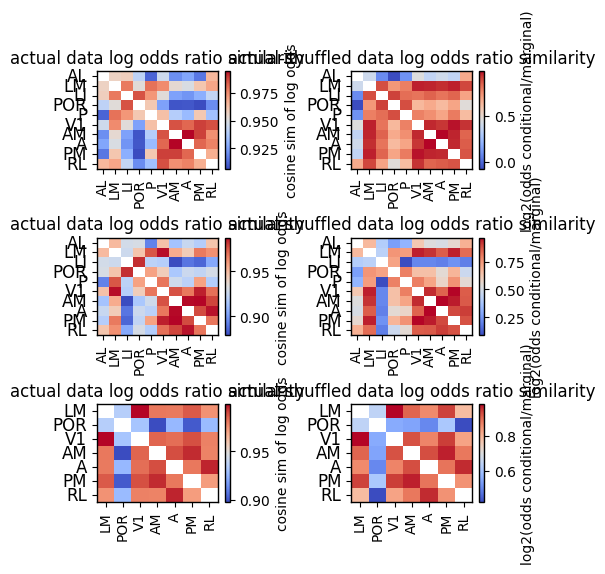

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(5, 5), constrained_layout=True)
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type == 'main':
        actual_data= conditional_probability_dict[f'area_is_{analysis_type}']    
    else:
        actual_data= conditional_probability_dict[f'homogenous_across_{analysis_type}']
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in actual_data.columns]
    minus_shuff = cond_prob_dif_dict[analysis_type]
    actual_cosine =  get_cosine_sim_of_probs(matrix=actual_data, cols = cols)
    minus_shuf_cosine= get_cosine_sim_of_probs(matrix= cond_prob_dif_dict[analysis_type], cols = cols)
    sb.heatmap(
                ax=axs[analysis_num, 0], 
                data=fpf.convert_matrix_names(actual_cosine), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'cosine sim of log odds'})
    axs[analysis_num, 0].set_title(f'actual data log odds ratio similarity')   
    sb.heatmap(
                ax=axs[analysis_num, 1], 
                data=fpf.convert_matrix_names(minus_shuf_cosine), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal)'})
    axs[analysis_num, 1].set_title(f'actual-shuffled data log odds ratio similarity')   
    axs[analysis_num, 1].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    for num in [0, 1]:
        axs[analysis_num, num].tick_params(axis='y', which='major', labelsize=12, rotation=0)  
        for _, spine in axs[analysis_num, num].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, num].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [21]:
from scipy.stats import spearmanr
def get_spearman_corr_of_probs(matrix, cols):
    spearman_corr_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    
    for col in cols:
        for col_2 in cols:
            if col != col_2:
                # Get the neuron values for both columns, dropping the diagonal values
                neurons_1 = matrix.loc[col].drop([col, col_2])
                neurons_2 = matrix.loc[col_2].drop([col, col_2])
                
                # Calculate Spearman correlation
                corr, _ = spearmanr(neurons_1, neurons_2)
                spearman_corr_matrix.loc[col, col_2] = corr
                spearman_corr_matrix.loc[col_2, col] = corr

    # Fill diagonal with NaN, as correlation with itself is not meaningful here
    np.fill_diagonal(spearman_corr_matrix.values, np.nan)
    
    return spearman_corr_matrix

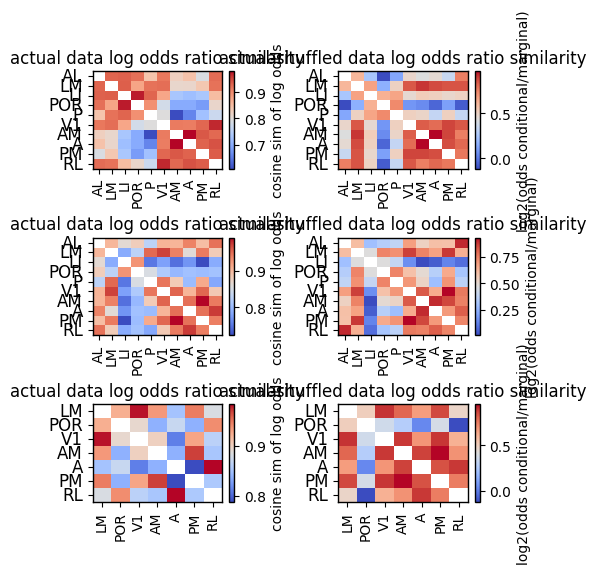

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(5, 5), constrained_layout=True)
for analysis_num, analysis_type in enumerate(['cubelet', 'area', 'main']):
    if analysis_type == 'main':
        actual_data= conditional_probability_dict[f'area_is_{analysis_type}']    
    else:
        actual_data= conditional_probability_dict[f'homogenous_across_{analysis_type}']
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in actual_data.columns]
    minus_shuff = cond_prob_dif_dict[analysis_type]
    actual_cosine =  get_spearman_corr_of_probs(matrix=actual_data, cols = cols)
    minus_shuf_cosine= get_spearman_corr_of_probs(matrix= cond_prob_dif_dict[analysis_type], cols = cols)
    sb.heatmap(
                ax=axs[analysis_num, 0], 
                data=fpf.convert_matrix_names(actual_cosine), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'cosine sim of log odds'})
    axs[analysis_num, 0].set_title(f'actual data log odds ratio similarity')   
    sb.heatmap(
                ax=axs[analysis_num, 1], 
                data=fpf.convert_matrix_names(minus_shuf_cosine), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(odds conditional/marginal)'})
    axs[analysis_num, 1].set_title(f'actual-shuffled data log odds ratio similarity')   
    axs[analysis_num, 1].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    for num in [0, 1]:
        axs[analysis_num, num].tick_params(axis='y', which='major', labelsize=12, rotation=0)  
        for _, spine in axs[analysis_num, num].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, num].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

Make a volcano plot showing odds marginal/ joint against p value vs shuffled

In [204]:
    

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
odds_dict = {}
for analysis_num, analysis_type in enumerate(analysis_names):
    smallest_probs = []
    barcodes = all_combined[analysis_type]
    odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'actual_vs_joint', 'mean_shuf', 'p_value'])  
    all_cols = barcodes.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in all_cols]
    for col in cols:
        for col_2 in cols_reordered:
            if col != col_2:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
                odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
    which = which_type[0]
    smallest_prob = odds.loc[['probs_actual', 'probs_joint']][odds > 0].min().min()  # Find the smallest non-zero probability
    smallest_probs.append(smallest_prob)
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
    shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            if separated_words[0] in cols or separated_words[1] in cols:
                shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
                shuff_joint_prob = (shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * (shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0])
                probabilities = pd.concat([shuff_actual_prob, shuff_joint_prob])
                non_zero_probabilities = probabilities[probabilities>0]
                smallest_probs.append(non_zero_probabilities.min())
    adjustment =  min(smallest_probs) * 0.1  
    for col in cols:
        for col_2 in cols_reordered:
            if col != col_2:
                probs_actual = odds.loc['probs_actual', f'{col}, {col_2}']
                probs_joint = odds.loc['probs_joint', f'{col}, {col_2}']
                actual_odds = (probs_actual + adjustment) / (1 - (probs_actual + adjustment))
                joint_odds = (probs_joint + adjustment) / (1 - (probs_joint + adjustment))
                odds.loc['actual_vs_joint', f'{col}, {col_2}'] = np.log2(actual_odds / joint_odds)
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            if separated_words[0] in cols or separated_words[1] in cols:
                shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
                shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
                shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
                shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
                oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
                shuff_log_odds = np.log2(oddd)
                mean_shuff_log_odds = shuff_log_odds.mean()
                if separated_words[0] in cols:
                    col = separated_words[0]
                    col_2 = separated_words[1]
                else:
                    col = separated_words[1]
                    col_2 = separated_words[0]
                val_to_comp = odds.loc['actual_vs_joint', f'{col}, {col_2}']
                if val_to_comp >= mean_shuff_log_odds:
                    p_val = (sum(1 for value in shuff_log_odds if value > val_to_comp)/len(shuff_log_odds))*2
                elif val_to_comp < mean_shuff_log_odds:
                    p_val = (sum(1 for value in shuff_log_odds if value < val_to_comp)/len(shuff_log_odds))*2    
                odds.loc['p_value', f'{col}, {col_2}'] = p_val
                odds.loc['mean_shuf', f'{col}, {col_2}'] = mean_shuff_log_odds
                if col in cols and col_2 in cols:
                    odds.loc['p_value', f'{col_2}, {col}'] = p_val
                    odds.loc['mean_shuf', f'{col_2}, {col}'] = mean_shuff_log_odds
    odds_dict[analysis_type] = odds
                

In [29]:
#alternative way to estimate pvalue so that no zeros    
from scipy.stats import norm
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
odds_dict = {}
for analysis_num, analysis_type in enumerate(analysis_names):
    smallest_probs = []
    barcodes = all_combined[analysis_type]
    odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'actual_vs_joint', 'mean_shuf', 'p_value'])  
    all_cols = barcodes.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in all_cols]
    for col in cols:
        for col_2 in cols_reordered:
            if col != col_2:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
                odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
    which = which_type[0]
    smallest_prob = odds.loc[['probs_actual', 'probs_joint']][odds > 0].min().min()  # Find the smallest non-zero probability
    smallest_probs.append(smallest_prob)
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
    shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            if separated_words[0] in cols or separated_words[1] in cols:
                shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
                shuff_joint_prob = (shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * (shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0])
                probabilities = pd.concat([shuff_actual_prob, shuff_joint_prob])
                non_zero_probabilities = probabilities[probabilities>0]
                smallest_probs.append(non_zero_probabilities.min())
    adjustment =  min(smallest_probs) * 0.1  
    for col in cols:
        for col_2 in cols_reordered:
            if col != col_2:
                probs_actual = odds.loc['probs_actual', f'{col}, {col_2}']
                probs_joint = odds.loc['probs_joint', f'{col}, {col_2}']
                actual_odds = (probs_actual + adjustment) / (1 - (probs_actual + adjustment))
                joint_odds = (probs_joint + adjustment) / (1 - (probs_joint + adjustment))
                odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
                odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
                odds.loc['actual_vs_joint', f'{col}, {col_2}'] = np.log2(actual_odds / joint_odds)
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            if separated_words[0] in cols or separated_words[1] in cols:
                shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
                shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
                shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
                shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
                oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
                
                shuff_log_odds = np.log2(oddd)
                mean_shuff_log_odds = shuff_log_odds.mean()
                if separated_words[0] in cols:
                    col = separated_words[0]
                    col_2 = separated_words[1]
                else:
                    col = separated_words[1]
                    col_2 = separated_words[0]
                val_to_comp = odds.loc['actual_vs_joint', f'{col}, {col_2}']
                #subtract_shuff = (odds.loc['odds_actual', f'{col}, {col_2}']/odds.loc['odds_joint', f'{col}, {col_2}']) - (oddd.mean())
                subtract_shuff = val_to_comp - mean_shuff_log_odds
                mu, std = norm.fit(shuff_log_odds)

                # Calculate the p-value based on the fitted distribution
                if val_to_comp >= mean_shuff_log_odds:
                    p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
                else:
                    p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
                # if val_to_comp >= mean_shuff_log_odds:
                #     p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
                # else:
                #     p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
                if p_val == 0:
                    print(col, col_2)
                odds.loc['p_value', f'{col}, {col_2}'] = p_val
                odds.loc['mean_shuf', f'{col}, {col_2}'] = subtract_shuff
                if col in cols and col_2 in cols:
                    odds.loc['p_value', f'{col_2}, {col}'] = p_val
                    odds.loc['mean_shuf', f'{col_2}, {col}'] = subtract_shuff
    odds_dict[analysis_type] = odds
                

In [34]:
#alternative way to estimate pvalue so that no zeros    
from scipy.stats import norm
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
odds_dict = {}
for analysis_num, analysis_type in enumerate(analysis_names):
    smallest_probs = []
    barcodes = all_combined[analysis_type]
    odds = pd.DataFrame(index=['probs_actual', 'probs_joint', 'actual_vs_joint', 'mean_shuf', 'p_value'])  
    all_cols = barcodes.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    cols = [col for col in cols if col in all_cols]
    for col in cols_reordered:
        for col_2 in cols_reordered:
            if col != col_2:
                prob_df = pd.DataFrame()
                prob_df["a"] = barcodes[col].astype(bool)
                prob_df["b"] = barcodes[col_2].astype(bool)
                prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
                probs_actual = prob_df["matching"].sum() / len(barcodes)
                probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
                odds.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
                odds.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in analysis_type]
    which = which_type[0]
    smallest_prob = odds.loc[['probs_actual', 'probs_joint']][odds > 0].min().min()  # Find the smallest non-zero probability
    smallest_probs.append(smallest_prob)
    shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
    shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
    shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            #if separated_words[0] in cols or separated_words[1] in cols:
            shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
            shuff_joint_prob = (shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * (shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0])
            probabilities = pd.concat([shuff_actual_prob, shuff_joint_prob])
            non_zero_probabilities = probabilities[probabilities>0]
            smallest_probs.append(non_zero_probabilities.min())
    adjustment =  min(smallest_probs) * 0.1  
    for col in cols_reordered:
        for col_2 in cols_reordered:
            if col != col_2:
                probs_actual = odds.loc['probs_actual', f'{col}, {col_2}']
                probs_joint = odds.loc['probs_joint', f'{col}, {col_2}']
                actual_odds = (probs_actual + adjustment) / (1 - (probs_actual + adjustment))
                joint_odds = (probs_joint + adjustment) / (1 - (probs_joint + adjustment))
                odds.loc['odds_actual', f'{col}, {col_2}'] = actual_odds
                odds.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
                odds.loc['actual_vs_joint', f'{col}, {col_2}'] = np.log2(actual_odds / joint_odds)
    
    for column_name in shuffled_2_combinations.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
            #if separated_words[0] in cols or separated_words[1] in cols:
            shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
            shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
            shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
            shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
            oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
            
            shuff_log_odds = np.log2(oddd)
            mean_shuff_log_odds = shuff_log_odds.mean()
            if column_name in odds.columns:
                col = separated_words[0]
                col_2 = separated_words[1]
            else:
                col = separated_words[1]
                col_2 = separated_words[0]
            val_to_comp = odds.loc['actual_vs_joint', f'{col}, {col_2}']
            #subtract_shuff = (odds.loc['odds_actual', f'{col}, {col_2}']/odds.loc['odds_joint', f'{col}, {col_2}']) - (oddd.mean())
            subtract_shuff = val_to_comp - mean_shuff_log_odds
            mu, std = norm.fit(shuff_log_odds)

            # Calculate the p-value based on the fitted distribution
            if val_to_comp >= mean_shuff_log_odds:
                p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
            else:
                p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
            # if val_to_comp >= mean_shuff_log_odds:
            #     p_val = norm.sf(val_to_comp, loc=mu, scale=std) * 2  # two-sided
            # else:
            #     p_val = norm.cdf(val_to_comp, loc=mu, scale=std) * 2
            if p_val == 0:
                print(col, col_2)
            
            odds.loc['p_value', f'{col}, {col_2}'] = p_val
            odds.loc['mean_shuf', f'{col}, {col_2}'] = subtract_shuff
            # if col in cols and col_2 in cols:
            odds.loc['p_value', f'{col_2}, {col}'] = p_val
            odds.loc['mean_shuf', f'{col_2}, {col}'] = subtract_shuff
    odds_dict[analysis_type] = odds
                

In [33]:
odds

,"VISl, VISpor","VISl, VISp","VISl, VISam","VISl, VISa","VISl, VISpm","VISl, VISrl","VISl, MOp","VISl, TEa","VISl, PERI","VISl, ACAd",...,"VISal, MOs","VISal, ACAv","VISal, ECT","VISal, SSs","VISal, AUDpo","VISal, AUDd","VISal, VISli","VISal, RSPagl","VISal, VISpl","VISal, AUDv"
probs_actual,0.072593,0.067222,0.042778,0.037963,0.034444,0.058704,0.011111,0.120000,0.030185,0.002593,...,0.026852,0.003519,0.142037,0.219815,0.402778,0.341111,0.106667,0.077593,0.023519,0.267963
probs_joint,0.027517,0.017201,0.014616,0.015943,0.009744,0.022714,0.005650,0.094400,0.024727,0.002082,...,0.018470,0.002579,0.149337,0.157158,0.213398,0.227375,0.072547,0.046839,0.014559,0.289606
actual_vs_joint,1.467959,2.041800,1.591109,1.284315,1.858092,1.424022,0.983670,0.387543,0.295876,0.317500,...,0.552247,0.449471,-0.084633,0.595523,1.313802,0.814900,0.610196,0.775510,0.705030,-0.155354
mean_shuf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.124890,NaN,NaN,0.003638,NaN
p_value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000010,NaN,NaN,0.942419,NaN
odds_actual,0.078275,0.072067,0.044689,0.039461,0.035673,0.062365,0.011236,0.136364,0.031125,0.002599,...,0.027593,0.003531,0.165551,0.281747,0.674419,0.517707,0.119403,0.084120,0.024085,0.366051
odds_joint,0.028296,0.017502,0.014833,0.016201,0.009840,0.023242,0.005682,0.104240,0.025353,0.002086,...,0.018817,0.002586,0.175554,0.186461,0.271291,0.294289,0.078222,0.049141,0.014774,0.407669


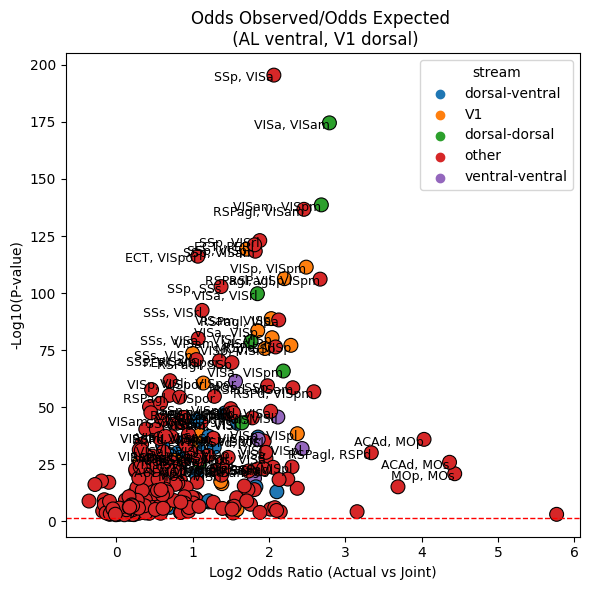

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `odds_dict`, `key`, and `odds_transposed` are already defined in your environment.
key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
new_columns = {}
for col in odds.columns:
    items = col.split(', ')
    sorted_col = ', '.join(sorted(items))
    new_columns[col] = sorted_col

# Rename columns in DataFrame
odds.rename(columns=new_columns, inplace=True)

# Drop duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = len(new_columns)
#odds.loc['p_value_corrected'] = odds.loc['p_value'] * number_of_tests
odds.loc['neg_log10_p_value'] = -np.log10(odds.loc['p_value'])
correction_factor_log = np.log10(number_of_tests)
odds.loc['neg_log10_p_value_corrected'] = odds.loc['neg_log10_p_value'] + correction_factor_log

ventral_stream = ['VISl', 'VISli', 'VISpor', 'VISpl']  
dorsal_stream = ['VISal', 'VISam', 'VISa', 'VISpm', 'VISrl', 'VISal']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']

for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if separated_words[0] in dorsal_stream and separated_words[1] in dorsal_stream:
        odds.loc['stream', column_name] = 'dorsal-dorsal'
    if separated_words[0] in ventral_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'ventral-ventral'
    if separated_words[0] in dorsal_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    if separated_words[1] in dorsal_stream and separated_words[0] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    elif separated_words[1] not in cols or separated_words[0] not in cols:
        if separated_words[1] =='VISp' or separated_words[0] =='VISp':
            odds.loc['stream', column_name] = 'V1'
        else:
            odds.loc['stream', column_name] = 'other'
            #odds.drop(columns=[column_name], inplace=True)
        
# Prepare data for plotting
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')

# Apply -log10 transformation
#odds_transposed['neg_log10_p_value'] = -np.log10(odds_transposed['p_value'])

# Filter significant points
p_value_cutoff = 20
significant = odds_transposed[
    (odds_transposed['neg_log10_p_value_corrected'] > p_value_cutoff) & (odds_transposed['actual_versus_joint'] > 1)
]

# First Plot: actual_versus_joint
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value_corrected', 
    edgecolor='k', hue='stream',
    s=100,
    ax=ax
)

ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
ax.set_title('Odds Observed/Odds Expected \n (AL ventral, V1 dorsal)')
ax.set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
ax.set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    ax.text(row['actual_versus_joint'], row['neg_log10_p_value'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()

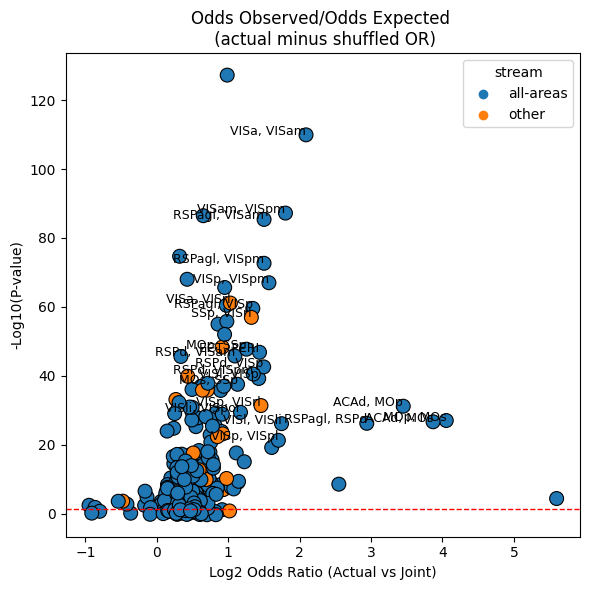

In [46]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `odds_dict` and `key` are already defined
key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
odds.columns = [', '.join(sorted(col.split(', '))) for col in odds.columns]

# Remove duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = odds.shape[1]
odds.loc['neg_log10_p_value'] = -np.log10(odds.loc['p_value'])
correction_factor_log = np.log10(number_of_tests)
odds.loc['neg_log10_p_value_corrected'] = odds.loc['neg_log10_p_value'] + correction_factor_log

# Group all areas
all_areas = odds.columns.str.split(', ').str.get(0).unique()
cols = list(all_areas)

# Assign stream labels
for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if len(set(separated_words) - set(cols)) == 0:
        odds.loc['stream', column_name] = 'all-areas'
    else:
        odds.loc['stream', column_name] = 'other'

# Prepare data for plotting
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')
odds_transposed['mean_shuff_numeric'] = pd.to_numeric(odds_transposed['mean_shuf'], errors='coerce')
odds_transposed['actual_versus_joint'] = odds_transposed['actual_versus_joint'] - odds_transposed['mean_shuff_numeric']

# Filter significant points
p_value_cutoff = 20
significant = odds_transposed[
    (odds_transposed['neg_log10_p_value_corrected'] > p_value_cutoff) & (odds_transposed['actual_versus_joint'] > 1)
]

# Scatter plot
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value_corrected', 
    edgecolor='k', hue='stream',
    s=100,
    ax=ax
)

# Add horizontal significance line
ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)

# Customize plot
ax.set_title('Odds Observed/Odds Expected \n (actual minus shuffled OR)')
ax.set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
ax.set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    ax.text(row['actual_versus_joint'], row['neg_log10_p_value_corrected'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()


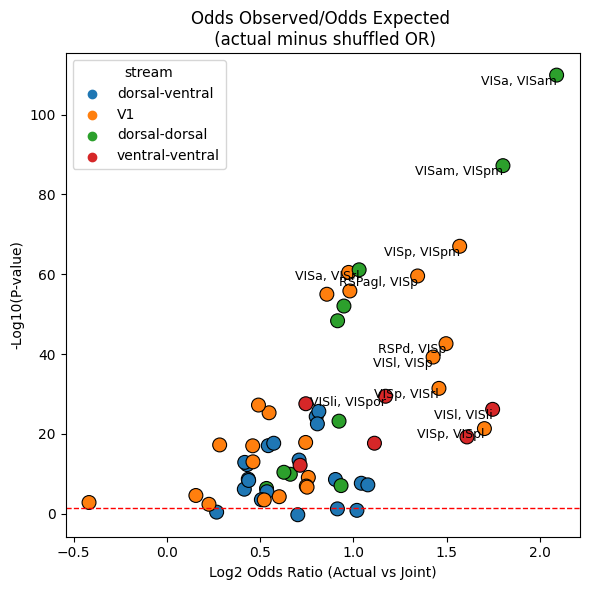

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `odds_dict`, `key`, and `odds_transposed` are already defined in your environment.
key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
new_columns = {}
for col in odds.columns:
    items = col.split(', ')
    sorted_col = ', '.join(sorted(items))
    new_columns[col] = sorted_col

# Rename columns in DataFrame
odds.rename(columns=new_columns, inplace=True)

# Drop duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = len(new_columns)
#odds.loc['p_value_corrected'] = odds.loc['p_value'] * number_of_tests
odds.loc['neg_log10_p_value'] = -np.log10(odds.loc['p_value'])
correction_factor_log = np.log10(number_of_tests)
odds.loc['neg_log10_p_value_corrected'] = odds.loc['neg_log10_p_value'] + correction_factor_log

ventral_stream = ['VISl', 'VISli', 'VISpor', 'VISpl']  
dorsal_stream = ['VISal', 'VISam', 'VISa', 'VISpm', 'VISrl', 'VISal']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']

for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if separated_words[0] in dorsal_stream and separated_words[1] in dorsal_stream:
        odds.loc['stream', column_name] = 'dorsal-dorsal'
    if separated_words[0] in ventral_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'ventral-ventral'
    if separated_words[0] in dorsal_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    if separated_words[1] in dorsal_stream and separated_words[0] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    elif separated_words[1] not in cols or separated_words[0] not in cols:
        if separated_words[1] =='VISp' or separated_words[0] =='VISp':
            odds.loc['stream', column_name] = 'V1'
        else:
            #odds.loc['stream', column_name] = 'other'
            odds.drop(columns=[column_name], inplace=True)
        
# Prepare data for plotting
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')
odds_transposed['mean_shuff_numeric'] = pd.to_numeric(odds_transposed['mean_shuf'], errors='coerce')
odds_transposed['actual_versus_joint']  = odds_transposed['actual_versus_joint'] -odds_transposed['mean_shuff_numeric']
# Apply -log10 transformation
#odds_transposed['neg_log10_p_value'] = -np.log10(odds_transposed['p_value'])

# Filter significant points
p_value_cutoff = 20
significant = odds_transposed[
    (odds_transposed['neg_log10_p_value_corrected'] > p_value_cutoff) & (odds_transposed['actual_versus_joint'] > 1)
]

# First Plot: actual_versus_joint
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value_corrected', 
    edgecolor='k', hue='stream',
    s=100,
    ax=ax
)

ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
ax.set_title('Odds Observed/Odds Expected \n (actual minus shuffled OR)')
ax.set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
ax.set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    ax.text(row['actual_versus_joint'], row['neg_log10_p_value'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()

In [15]:
odds_dict[key]

,"VISal, VISl","VISal, VISli","VISal, VISpor","VISal, VISpl","VISal, VISp","VISal, VISam","VISa, VISal","VISal, VISpm","VISal, VISrl","MOs, VISal",...,"PERI, RSPd","AUDpo, RSPd","RSPagl, RSPd","MOp, RSPd","RSPd, TEa","ECT, RSPd","ACAd, RSPd","RSPd, SSs","AUDd, RSPd","ACAv, RSPd"
probs_actual,1.109259e-01,1.066667e-01,0.121111,0.023519,1.164815e-01,0.094444,9.185185e-02,6.388889e-02,0.161667,2.685185e-02,...,0.017963,0.050926,0.068333,1.370370e-02,0.064630,0.026481,0.003333,0.044444,0.051481,0.001481
probs_joint,5.549184e-02,7.254705e-02,0.100085,0.014559,6.256351e-02,0.053162,5.798772e-02,3.544156e-02,0.082614,1.846955e-02,...,0.013791,0.032722,0.007182,3.151029e-03,0.052649,0.022899,0.001161,0.024098,0.034865,0.000395
actual_vs_joint,1.086386e+00,6.101361e-01,0.309190,0.704671,9.820671e-01,0.893263,7.162928e-01,8.931396e-01,1.098493,5.520148e-01,...,0.387233,0.665389,3.340077,2.132676e+00,0.314104,0.214906,1.517192,0.913204,0.587184,1.881891
mean_shuf,3.201508e-01,3.290926e-01,NaN,0.206140,3.997626e-01,NaN,3.852369e-01,4.683310e-01,NaN,4.569434e-01,...,NaN,NaN,NaN,2.056482e+00,NaN,NaN,2.927259,NaN,NaN,NaN
p_value,3.455070e-29,4.688731e-31,NaN,0.000562,1.010842e-30,NaN,5.944023e-27,6.794773e-29,NaN,1.357483e-13,...,NaN,NaN,NaN,3.555598e-16,NaN,NaN,0.003123,NaN,NaN,NaN
odds_actual,1.247777e-01,1.194149e-01,0.137813,0.024095,1.318504e-01,0.104306,1.011535e-01,6.826012e-02,0.192856,2.760282e-02,...,0.018301,0.053669,0.073356,1.390389e-02,0.069106,0.027212,0.003354,0.046522,0.054286,0.001493
odds_joint,5.876277e-02,7.823288e-02,0.111228,0.014784,6.674976e-02,0.056158,6.156801e-02,3.675405e-02,0.090065,1.882697e-02,...,0.013993,0.033839,0.007244,3.170565e-03,0.055586,0.023446,0.001172,0.024703,0.036135,0.000405


NameError: name 'odds_transposed' is not defined

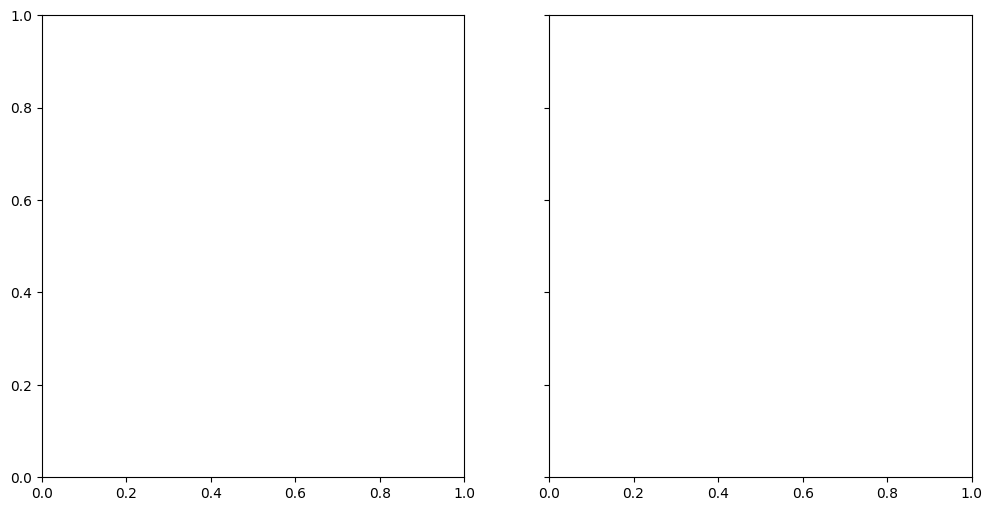

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
new_columns = {}
for col in odds.columns:
    items = col.split(', ')
    sorted_col = ', '.join(sorted(items))
    new_columns[col] = sorted_col

# Rename columns in DataFrame
odds.rename(columns=new_columns, inplace=True)

# Drop duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = len(new_columns)
odds.loc['p_value'] = odds.loc['p_value'] * number_of_tests
#odds.loc['actual_minus_shuff'] = odds.loc['actual_vs_joint'] - odds.loc['mean_shuf']
# Prepare data for plotting
# Annotate significant points
p_value_cutoff = 1e-50
neg_log10_p_value_cutoff = -np.log10(p_value_cutoff)
significant = odds_transposed[
    (odds_transposed['p_value'] < p_value_cutoff)  & (odds_transposed['actual_vs_joint'] > 1)
]
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['p_value'] = pd.to_numeric(odds_transposed['p_value'], errors='coerce')
odds_transposed['mean_shuf'] = pd.to_numeric(odds_transposed['mean_shuf'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')
# Apply -log10 transformation
odds_transposed['neg_log10_p_value'] = -np.log10(odds_transposed['p_value'])

# First Plot: actual_versus_joint
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value', 
    edgecolor='k',
    s=100,
    ax=axes[0]
)

axes[0].axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
axes[0].set_title('Odds Observed/Odds Expected')
axes[0].set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
axes[0].set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    axes[0].text(row['actual_versus_joint'], row['neg_log10_p_value'], row['condition_pair'], fontsize=9, ha='right')

# Second Plot: actual_minus_shuff
sb.scatterplot(
    data=odds_transposed,
    x='mean_shuf',
    y='neg_log10_p_value', 
    edgecolor='k',
    s=100,
    ax=axes[1]
)

axes[1].axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
axes[1].set_title('Odds Observed/Odds Expected Minus Shuffled')
axes[1].set_xlabel('Log2 Odds Ratio (Actual vs joint - Shuffled vs joint)')

# Annotate significant points with the same criteria
for _, row in significant.iterrows():
    axes[1].text(row['mean_shuf'], row['neg_log10_p_value'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()

In [46]:
odds2

,"VISal, VISl","VISal, VISpor","VISal, VISp","VISal, VISam","VISa, VISal","VISal, VISpm","VISal, VISrl","ACAv, VISal","ACAd, VISal","VISal, VISli",...,"SSp, VISrl","RSPd, VISrl","TEa, VISrl","PERI, VISrl","SSs, VISrl","AUDd, VISrl","MOs, VISrl","ECT, VISrl","AUDv, VISrl","MOp, VISrl"
probs_actual,1.109259e-01,1.211111e-01,1.164815e-01,9.444444e-02,9.185185e-02,6.388889e-02,1.616667e-01,0.003519,5.925926e-03,1.066667e-01,...,1.175926e-01,3.425926e-02,1.637037e-01,0.037963,1.303704e-01,1.542593e-01,1.944444e-02,0.056111,0.107778,2.203704e-02
probs_joint,5.549184e-02,1.000850e-01,6.256351e-02,5.316235e-02,5.798772e-02,3.544156e-02,8.261379e-02,0.002579,7.570850e-03,7.254705e-02,...,3.493889e-02,1.266790e-02,1.405388e-01,0.036812,6.432706e-02,9.306821e-02,7.559877e-03,0.061126,0.118540,8.411214e-03
actual_vs_joint,1.086301e+00,3.091741e-01,9.819975e-01,8.931853e-01,7.162328e-01,8.930207e-01,1.098438e+00,0.447079,-3.549546e-01,6.100946e-01,...,1.879602e+00,1.466062e+00,2.595143e-01,0.046129,1.124541e+00,8.296782e-01,1.378430e+00,-0.131152,-0.154806,1.407802e+00
mean_shuf,3.200460e-01,2.626569e-01,3.996679e-01,4.204308e-01,3.851379e-01,4.681578e-01,2.567310e-01,0.958370,1.136253e+00,3.290070e-01,...,6.882045e-01,1.017163e+00,2.504875e-01,-0.201971,7.918986e-01,5.832097e-01,1.262203e+00,-0.069544,-0.150726,1.293036e+00
p_value,3.581123e-29,1.302918e-14,1.038098e-30,7.005704e-32,6.089290e-27,7.036444e-29,1.449906e-23,0.000047,9.503155e-07,4.822730e-31,...,6.619596e-121,7.106854e-26,8.515714e-20,0.001707,2.460618e-90,2.595604e-52,4.227416e-18,0.142740,0.000032,1.650077e-20
odds_actual,1.247860e-01,1.378211e-01,1.318588e-01,1.043141e-01,1.011614e-01,6.826763e-02,1.928658e-01,0.003547,5.977543e-03,1.194232e-01,...,1.332841e-01,3.549185e-02,1.957715e-01,0.039478,1.499361e-01,1.824180e-01,1.984677e-02,0.059465,0.120817,2.255044e-02
odds_joint,5.877015e-02,1.112359e-01,6.675725e-02,5.616522e-02,6.157543e-02,3.676113e-02,9.007257e-02,0.002602,7.644950e-03,7.824053e-02,...,3.622109e-02,1.284695e-02,1.635414e-01,0.038236,6.876790e-02,1.026383e-01,7.633808e-03,0.065124,0.134502,8.498935e-03
neg_log10_p_value,2.844598e+01,1.388508e+01,2.998376e+01,3.115455e+01,2.621543e+01,2.815265e+01,2.283866e+01,4.330653,6.022132e+00,3.031671e+01,...,1.201792e+02,2.514832e+01,1.906978e+01,2.767720,8.960896e+01,5.158576e+01,1.737393e+01,0.845454,4.499487,1.978250e+01


In [59]:
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_versus_joint'], errors='coerce')
print(odds_transposed[['neg_log10_p_value_corrected', 'actual_versus_joint']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neg_log10_p_value_corrected  185 non-null    float64
 1   actual_versus_joint          185 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB
None


In [61]:
print(odds_transposed[['neg_log10_p_value_corrected', 'actual_versus_joint']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neg_log10_p_value_corrected  185 non-null    object 
 1   actual_versus_joint          185 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB
None


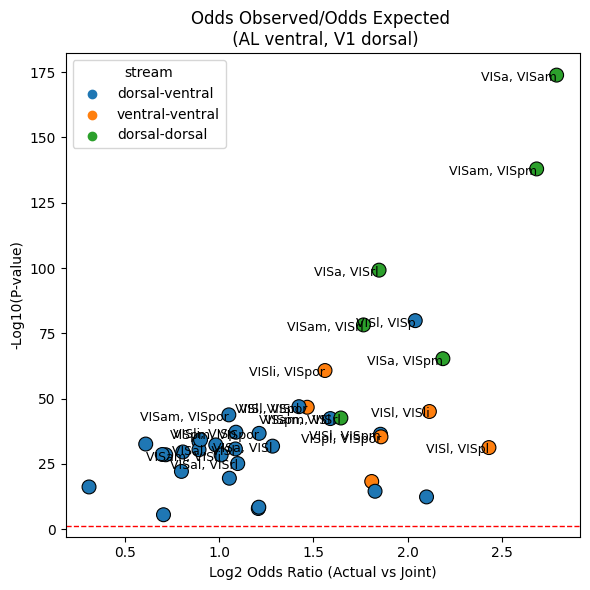

In [71]:
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `odds_dict`, `key`, and `odds_transposed` are already defined in your environment.
key = 'homogenous_across_cubelet'
odds = odds_dict[key]

# Standardize column names to ensure all pairs are in alphabetical order
new_columns = {}
for col in odds.columns:
    items = col.split(', ')
    sorted_col = ', '.join(sorted(items))
    new_columns[col] = sorted_col

# Rename columns in DataFrame
odds.rename(columns=new_columns, inplace=True)

# Drop duplicate columns by keeping the first occurrence of each unique pair
odds = odds.loc[:, ~odds.columns.duplicated()]

# Apply Bonferroni correction for multiple comparisons
number_of_tests = len(new_columns)
#odds.loc['p_value_corrected'] = odds.loc['p_value'] * number_of_tests
odds.loc['neg_log10_p_value'] = -np.log10(odds.loc['p_value'])
correction_factor_log = np.log10(number_of_tests)
odds.loc['neg_log10_p_value_corrected'] = odds.loc['neg_log10_p_value'] + correction_factor_log

ventral_stream = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl']  
dorsal_stream = ['VISp', 'VISam', 'VISa', 'VISpm', 'VISrl', 'VISal']
cols = ['VISp,', 'VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISam', 'VISa', 'VISpm', 'VISrl']

for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if separated_words[0] in dorsal_stream and separated_words[1] in dorsal_stream:
        odds.loc['stream', column_name] = 'dorsal-dorsal'
    if separated_words[0] in ventral_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'ventral-ventral'
    if separated_words[0] in dorsal_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    if separated_words[1] in dorsal_stream and separated_words[0] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    elif separated_words[1] not in cols or separated_words[0] not in cols:
        odds.drop(columns=[column_name], inplace=True)
        
# Prepare data for plotting
odds_transposed = odds.T.reset_index()
odds_transposed.rename(columns={'index': 'condition_pair'}, inplace=True)

# Convert columns to numeric types
odds_transposed['neg_log10_p_value_corrected'] = pd.to_numeric(odds_transposed['neg_log10_p_value_corrected'], errors='coerce')
odds_transposed['actual_versus_joint'] = pd.to_numeric(odds_transposed['actual_vs_joint'], errors='coerce')

# Apply -log10 transformation
#odds_transposed['neg_log10_p_value'] = -np.log10(odds_transposed['p_value'])

# Filter significant points
p_value_cutoff = 20
significant = odds_transposed[
    (odds_transposed['neg_log10_p_value_corrected'] > p_value_cutoff) & (odds_transposed['actual_versus_joint'] > 1)
]

# First Plot: actual_versus_joint
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value_corrected', 
    edgecolor='k', hue='stream',
    s=100,
    ax=ax
)

ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
ax.set_title('Odds Observed/Odds Expected \n (AL ventral, V1 dorsal)')
ax.set_xlabel('Log2 Odds Ratio (Actual vs Joint)')
ax.set_ylabel('-Log10(P-value)')

# Annotate significant points
for _, row in significant.iterrows():
    ax.text(row['actual_versus_joint'], row['neg_log10_p_value'], row['condition_pair'], fontsize=9, ha='right')

plt.tight_layout()
plt.show()

In [6]:
ventral_stream = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl']  
dorsal_stream = ['VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
for column_name in odds.columns:
    separated_words = column_name.split(', ')
    if separated_words[0] in dorsal_stream and separated_words[1] in dorsal_stream:
        odds.loc['stream', column_name] = 'dorsal-dorsal'
    if separated_words[0] in ventral_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'ventral-ventral'
    if separated_words[0] in dorsal_stream and separated_words[1] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'
    if separated_words[1] in dorsal_stream and separated_words[0] in ventral_stream:
        odds.loc['stream', column_name] = 'dorsal-ventral'

In [7]:
odds

,"VISl, VISpor","VISl, VISp","VISl, VISam","VISl, VISa","VISl, VISpm","VISl, VISrl","VISl, ACAv","VISl, RSPagl","VISl, AUDpo","VISl, SSp",...,"VISrl, RSPagl","VISrl, AUDpo","VISrl, SSp","VISrl, RSPd","VISrl, TEa","VISrl, SSs","VISrl, AUDd","VISrl, MOs","VISrl, AUDv","VISrl, MOp"
probs_actual,0.029401,0.036846,0.022337,0.029591,0.017564,0.02501,0.001145,0.003246,6.643757e-02,1.794578e-02,...,0.003246,7.235586e-02,3.722795e-02,1.718213e-02,7.980145e-02,3.550974e-02,6.166476e-02,8.018328e-03,0.040473,9.927453e-03
probs_joint,0.014225,0.007481,0.004952,0.009152,0.003537,0.007541,0.000421,0.001189,3.514843e-02,8.113492e-03,...,0.001443,4.263769e-02,9.842275e-03,5.240692e-03,6.232224e-02,1.258131e-02,3.723265e-02,2.684257e-03,0.043058,2.209490e-03
actual_vs_joint,1.068833,2.340644,2.194463,1.721057,2.326287,1.752707,1.404558,1.437373,9.657426e-01,1.157821e+00,...,1.162229,8.082179e-01,1.957793e+00,1.726969e+00,3.837217e-01,1.529458e+00,7.646781e-01,1.579925e+00,-0.093145,2.169560e+00
mean_shuf,1.210882,1.836715,1.617075,1.258458,1.812948,1.274892,2.230924,2.115766,4.845778e-01,1.219473e+00,...,1.582193,4.648779e-01,1.935683e+00,1.294418e+00,3.353060e-01,1.598819e+00,6.238624e-01,1.658204e+00,0.008193,1.929786e+00
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.143455,0.006031,1.871916e-22,1.804686e-13,...,0.005838,2.271753e-21,2.862268e-41,5.636517e-13,1.932840e-19,2.056648e-30,2.359993e-22,5.503201e-08,0.903643,1.164140e-09
odds_actual,0.030311,0.038276,0.022866,0.030513,0.017897,0.025671,0.001165,0.003275,7.118689e-02,1.829292e-02,...,0.003275,7.802111e-02,3.868744e-02,1.750169e-02,8.674386e-02,3.683701e-02,6.573823e-02,8.101960e-03,0.042201,1.004589e-02
odds_joint,0.014449,0.007556,0.004996,0.009256,0.003569,0.007618,0.000440,0.001209,3.644874e-02,8.198683e-03,...,0.001463,4.455683e-02,9.958997e-03,5.287016e-03,6.648551e-02,1.276061e-02,3.869251e-02,2.710100e-03,0.045015,2.232984e-03
stream,ventral-ventral,dorsal-ventral,dorsal-ventral,dorsal-ventral,dorsal-ventral,dorsal-ventral,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
odds.loc['actual_minus_shuff'] = odds.loc['actual_vs_joint'] - odds.loc['mean_shuf']

In [234]:
odds

,"VISal, VISl","VISal, VISpor","VISal, VISp","VISal, VISam","VISa, VISal","VISal, VISpm","VISal, VISrl","AUDv, VISal","ACAd, VISal","MOp, VISal",...,"TEa, VISrl","RSPd, VISrl","MOs, VISrl","ACAv, VISrl","SSs, VISrl","SSp, VISrl","RSPagl, VISrl","ECT, VISrl","AUDd, VISrl","AUDpo, VISrl"
probs_actual,0.110926,1.211111e-01,0.116481,0.094444,0.091852,0.063889,0.161667,0.267963,0.005926,2.907407e-02,...,0.163704,0.034259,0.019444,0.002778,0.130370,0.117593,0.052037,0.056111,0.154259,0.148333
probs_joint,0.055492,1.000850e-01,0.062564,0.053162,0.057988,0.035442,0.082614,0.289606,0.007571,2.054945e-02,...,0.140539,0.012668,0.007560,0.001056,0.064327,0.034939,0.019172,0.061126,0.093068,0.087347
actual_vs_joint,1.086301,3.091741e-01,0.981998,0.893185,0.716233,0.893021,1.098438,-0.155348,-0.354955,5.129139e-01,...,0.259514,1.466062,1.378430,1.384780,1.124541,1.879602,1.488934,-0.131152,0.829678,0.863679
mean_shuf,0.766255,4.651721e-02,0.582330,0.472755,0.331095,0.424863,0.841707,-0.002345,-1.491208,9.848156e-02,...,0.009027,0.448899,0.116227,-0.501147,0.332642,1.191398,0.334779,-0.061608,0.246468,0.346219
p_value,0.000000,2.423617e-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000046,0.000176,5.708645e-10,...,0.000000,0.000000,0.000000,0.265541,0.000000,0.000000,0.000000,26.406914,0.000000,0.000000
actual_minus_shuff,0.320046,2.626569e-01,0.399668,0.420431,0.385138,0.468158,0.256731,-0.153004,1.136253,4.144323e-01,...,0.250488,1.017163,1.262203,1.885927,0.791899,0.688205,1.154155,-0.069544,0.583210,0.517460


In [163]:
which = 'cubelet'
shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_{which}__collated.pkl')
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_2_comb__collated.pkl')
shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_{which}__collated.pkl')

In [195]:
#cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
separated_words[0] = 'VISpor'
separated_words[1] = 'VISal'
if separated_words[0] in cols or separated_words[1] in cols:
    shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
    shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
    shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
    shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
    oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
    shuff_log_odds = np.log2(oddd)
    mean_shuff_log_odds = shuff_log_odds.mean()
    if separated_words[0] in cols:
        col = separated_words[0]
        col_2 = separated_words[1]
    else:
        col = separated_words[1]
        col_2 = separated_words[0]
    val_to_comp = odds_dict['homogenous_across_cubelet'].loc['actual_vs_joint', f'{col}, {col_2}']
    if val_to_comp >= mean_shuff_log_odds:
        p_val = (sum(1 for value in shuff_log_odds if value > val_to_comp)/len(shuff_log_odds))*2
    elif val_to_comp < mean_shuff_log_odds:
        p_val = (sum(1 for value in shuff_log_odds if value < val_to_comp)/len(shuff_log_odds))*2    
    odds_dict['homogenous_across_cubelet'].loc['p_value', f'{col}, {col_2}'] = p_val
    if col in cols and col_2 in cols:
        print(p_val)
        #odds.loc['p_value', f'{col_2}, {col}'] = p_val

KeyError: 'VISal'

In [191]:
cols

['VISl', 'VISpor', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']

In [156]:
odds_dict['homogenous_across_cubelet'].loc['p_value', f'{col}, {col_2}']

0.0

In [157]:
odds_dict['homogenous_across_cubelet']


,"VISl, VISpor","VISl, VISp","VISl, VISam","VISl, VISa","VISl, VISpm","VISl, VISrl","VISl, AUDv","VISl, ACAd","VISl, MOp","VISl, VISal",...,"VISrl, RSPd","VISrl, MOs","VISrl, ACAv","VISrl, SSs","VISrl, SSp","VISrl, RSPagl","VISrl, ECT","VISrl, AUDd","VISrl, VISli","VISrl, AUDpo"
probs_actual,0.072593,0.067222,0.042778,0.037963,0.034444,0.058704,0.082407,0.002593,0.011111,0.110926,...,0.034259,0.019444,0.002778,0.130370,0.117593,0.052037,0.056111,0.154259,0.054074,0.148333
probs_joint,0.027517,0.017201,0.014616,0.015943,0.009744,0.022714,0.079624,0.002082,0.005650,0.055492,...,0.012668,0.007560,0.001056,0.064327,0.034939,0.019172,0.061126,0.093068,0.029695,0.087347
actual_vs_joint,1.467358,2.040647,1.589908,1.283345,1.856129,1.423303,0.053935,0.314990,0.981351,1.086270,...,1.465889,1.378148,1.382775,1.124513,1.879532,1.488820,-0.131147,0.829664,0.901041,0.863663
p_value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000480,0.000000,0.032320,NaN,...,0.000000,0.000000,0.002720,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000


In [129]:
odds_dict

{'homogenous_across_cubelet':                  VISl, VISpor  VISl, VISp  VISl, VISam  VISl, VISa  \
 probs_actual         0.072593    0.067222     0.042778    0.037963   
 probs_joint          0.027517    0.017201     0.014616    0.015943   
 actual_vs_joint      1.467358    2.040647     1.589908    1.283345   
 p_value              0.000000    0.000000     0.000000    0.000000   
 
                  VISl, VISpm  VISl, VISrl  VISl, AUDv  VISl, ACAd  VISl, MOp  \
 probs_actual        0.034444     0.058704    0.082407    0.002593   0.011111   
 probs_joint         0.009744     0.022714    0.079624    0.002082   0.005650   
 actual_vs_joint     1.856129     1.423303    0.053935    0.314990   0.981351   
 p_value             0.000000     0.000000    0.000480         NaN   0.032320   
 
                  VISl, VISal  ...  VISrl, RSPd  VISrl, MOs  VISrl, ACAv  \
 probs_actual        0.110926  ...     0.034259    0.019444     0.002778   
 probs_joint         0.055492  ...     0.012668    0.00

In [123]:
key = homogenous_across_cubelet

In [124]:
if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
    if separated_words[0] in cols or separated_words[1] in cols:
        shuff_actual_prob = (shuffled_2_combinations[column_name]/shuffle_total_numbers[0]) + adjustment
        shuff_joint_prob = ((shuffled_numbers[separated_words[0]]/shuffle_total_numbers[0]) * ((shuffled_numbers[separated_words[1]]/shuffle_total_numbers[0]) + adjustment))
        shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
        shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
        oddd = (shuff_odds_actual/shuff_odds_joint).astype(float)
        shuff_log_odds = np.log2(oddd)
        mean_shuff_log_odds = shuff_log_odds.mean()
        if separated_words[0] in cols:
            col = separated_words[0]
            col_2 = separated_words[1]
        
        else:
            col = separated_words[1]
            col_2 = separated_words[0]
        val_to_comp = odds.loc['actual_vs_joint', f'{col}, {col_2}']
        if val_to_comp >= mean_shuff_log_odds:
            p_val = (sum(1 for value in shuff_log_odds if value > val_to_comp)/len(shuff_log_odds))*2
        elif val_to_comp < mean_shuff_log_odds:
            p_val = (sum(1 for value in shuff_log_odds if value < val_to_comp)/len(shuff_log_odds))*2    

In [127]:
odds[f'{col_2}, {col}']

probs_actual       0.029591
probs_joint        0.009152
actual_vs_joint    1.721057
p_value                 NaN
Name: VISa, VISl, dtype: float64

In [126]:
col

'VISl'

In [121]:
odds

,"VISl, VISpor","VISl, VISp","VISl, VISam","VISl, VISa","VISl, VISpm","VISl, VISrl","VISl, AUDv","VISl, MOp","VISl, TEa","VISl, RSPd",...,"VISrl, MOp","VISrl, TEa","VISrl, RSPd","VISrl, MOs","VISrl, ACAv","VISrl, SSs","VISrl, SSp","VISrl, RSPagl","VISrl, AUDd","VISrl, AUDpo"
probs_actual,0.029401,0.036846,0.022337,0.029591,0.017564,0.025010,0.028637,0.006300,0.075601,0.022719,...,0.009927,0.079801,0.017182,0.008018,0.001145,0.035510,0.037228,0.003246,0.061665,0.072356
probs_joint,0.014225,0.007481,0.004952,0.009152,0.003537,0.007541,0.035495,0.001821,0.051375,0.004320,...,0.002209,0.062322,0.005241,0.002684,0.000511,0.012581,0.009842,0.001443,0.037233,0.042638
actual_vs_joint,1.068833,2.340644,2.194463,1.721057,2.326287,1.752707,-0.319768,1.786461,0.594491,2.416626,...,2.169560,0.383722,1.726969,1.579925,1.136464,1.529458,1.957793,1.162229,0.764678,0.808218
p_value,NaN,NaN,NaN,0.000000,0.000000,NaN,0.152520,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.014680,0.000000,0.000000,0.000000,0.000000,0.000000


In [104]:
413/32.56376479572356

12.682808716707022

In [103]:
probs_joint*(len(barcodes))

32.56376479572356

In [94]:
plt.figure(figsize=(10, 6))
sb.scatterplot(
    data=odds_transposed,
    x='actual_versus_joint',
    y='neg_log10_p_value',
    hue='neg_log10_p_value',  # Optional: color points by significance
    palette='viridis',
    edgecolor='k',
    s=100
)

# Add horizontal line for p-value cutoff (e.g., p = 0.05)
p_value_cutoff = 0.05
neg_log10_p_value_cutoff = -np.log10(p_value_cutoff)
plt.axhline(y=neg_log10_p_value_cutoff, color='red', linestyle='--', linewidth=1)

# Add vertical lines for fold-change cutoffs (e.g., log2(1.5) and log2(0.67))
fold_change_cutoff = np.log2(1.5)
plt.axvline(x=fold_change_cutoff, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=-fold_change_cutoff, color='gray', linestyle='--', linewidth=1)

# Labeling
plt.title('Volcano Plot')
plt.xlabel('Log2 Odds Ratio (Actual vs Joint)')
plt.ylabel('-Log10(P-value)')

# Optionally, annotate significant points
significant = odds_transposed[
    (odds_transposed['p_value'] < p_value_cutoff) &
    (abs(odds_transposed['actual_versus_joint']) > fold_change_cutoff)
]
for _, row in significant.iterrows():
    plt.text(
        row['actual_versus_joint'],
        row['neg_log10_p_value'],
        row['condition_pair'],
        fontsize=9,
        ha='right'
    )

plt.tight_layout()
plt.show()

0.00828

In [96]:
odds

,"VISl, VISl","VISl, VISpor","VISl, VISp","VISl, VISam","VISl, VISa","VISl, VISpm","VISl, VISrl","VISl, AUDv","VISl, MOp","VISl, TEa",...,"VISrl, MOp","VISrl, TEa","VISrl, RSPd","VISrl, MOs","VISrl, ACAv","VISrl, SSs","VISrl, SSp","VISrl, RSPagl","VISrl, AUDd","VISrl, AUDpo"
probs_actual,0.078847,0.029401,0.036846,0.022337,0.029591,0.017564,0.025010,0.028637,0.006300,0.075601,...,0.009927,0.079801,0.017182,0.008018,0.001145,0.035510,0.037228,0.003246,0.061665,0.072356
probs_joint,0.006217,0.014225,0.007481,0.004952,0.009152,0.003537,0.007541,0.035495,0.001821,0.051375,...,0.002209,0.062322,0.005241,0.002684,0.000511,0.012581,0.009842,0.001443,0.037233,0.042638
actual_vs_joint,3.770342,1.068833,2.340644,2.194463,1.721057,2.326287,1.752707,-0.319768,1.786461,0.594491,...,2.169560,0.383722,1.726969,1.579925,1.136464,1.529458,1.957793,1.162229,0.764678,0.808218
p_value,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.152520,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.014680,0.000000,0.000000,0.000000,0.000000,0.000000


In [88]:
odds.loc['probs_actual', f'VISl, VISpor']

0.02940053455517373

In [48]:
odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)

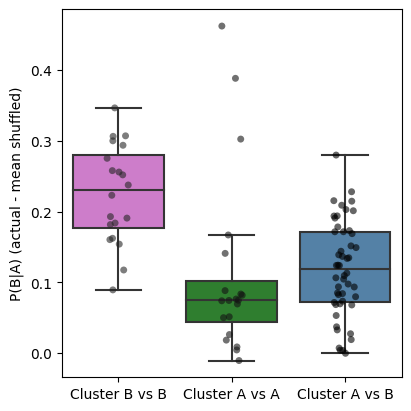

In [44]:
from scipy.stats import ttest_ind, mannwhitneyu
def significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'ns'  # not significant
def add_significance_line(ax, x1, x2, y, significance, offset=0.05):
    """
    Draws a significance line with stars between two x coordinates.
    ax: The axes to draw the line on.
    x1, x2: The positions of the two groups being compared.
    y: The height at which the line should be drawn.
    significance: The significance label to put above the line.
    offset: Offset between the line and the text.
    """
    ax.plot([x1, x1, x2, x2], [y, y + offset, y + offset, y], lw=1.5, color='black')
    ax.text((x1 + x2) * 0.5, y + offset, significance, ha='center', va='bottom', color='grey', fontsize=16)
colors = ['orchid', 'forestgreen', 'steelblue']   
fig, axs = plt.subplots(1, figsize=(4, 4), constrained_layout=True)
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
comparing = ['actual - shuffle']
for analysis_num, analysis_type in enumerate(['cubelet']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    
    # Deep copy to avoid modification of original data
    orig_df = actual_data.copy(deep=True)
    
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = actual_data / conditional_probability_dict[f'shuff_{analysis_type}']
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    for numero, which_shuff in enumerate([combined_dif]):
        # ventral_stream = ['LM', 'LI', 'POR', 'P']  # Update to correct dorsal areas
        # dorsal_stream = ['AL', 'AM', 'A', 'PM', 'RL']  # Update to correct ventral areas
        ventral_stream = ['AL', 'LM', 'LI', 'POR', 'P']  # Update to correct dorsal areas
        dorsal_stream = ['V1', 'AM', 'A', 'PM', 'RL']
        which_shuff = fpf.convert_matrix_names(which_shuff)
        dorsal_stream = [col for col in dorsal_stream if col in which_shuff.columns]
        ventral_stream = [col for col in ventral_stream if col in which_shuff.columns]

        # Extract intra-stream values (Dorsal-Dorsal and Ventral-Ventral)
        dorsal_intra = which_shuff.loc[dorsal_stream, dorsal_stream].values.flatten()
        ventral_intra = which_shuff.loc[ventral_stream, ventral_stream].values.flatten()
        dorsal_intra = [x for x in dorsal_intra if not np.isnan(x)]
        ventral_intra = [x for x in ventral_intra if not np.isnan(x)]
        # Extract inter-stream values (Dorsal-Ventral and Ventral-Dorsal)
        dorsal_to_ventral = which_shuff.loc[dorsal_stream, ventral_stream].values.flatten()
        ventral_to_dorsal = which_shuff.loc[ventral_stream, dorsal_stream].values.flatten()

        # Combine dorsal-to-ventral and ventral-to-dorsal into one group
        inter_stream = np.concatenate([dorsal_to_ventral, ventral_to_dorsal])

        # Perform a statistical comparison within each group
        # Compare dorsal-to-dorsal vs ventral-to-ventral
        t_stat_dd_vv, p_value_dd_vv = ttest_ind(dorsal_intra, ventral_intra, nan_policy='omit')
        u_stat_dd_vv, p_value_mw_dd_vv = mannwhitneyu(dorsal_intra, ventral_intra, alternative='two-sided')

        # Compare dorsal-to-dorsal vs dorsal-to-ventral
        t_stat_dd_dv, p_value_dd_dv = ttest_ind(dorsal_intra, inter_stream, nan_policy='omit')
        u_stat_dd_dv, p_value_mw_dd_dv = mannwhitneyu(dorsal_intra, inter_stream, alternative='two-sided')

        # Compare ventral-to-ventral vs dorsal-to-ventral
        t_stat_vv_dv, p_value_vv_dv = ttest_ind(ventral_intra, inter_stream, nan_policy='omit')
        u_stat_vv_dv, p_value_mw_vv_dv = mannwhitneyu(dorsal_intra, inter_stream, alternative='two-sided')
        data_to_plot = [dorsal_intra, ventral_intra, inter_stream]
        labels = ['Cluster B vs B', 'Cluster A vs A', 'Cluster A vs B']
        max_y = max(max(dorsal_intra), max(ventral_intra), max(inter_stream))-0.06
        sb.boxplot(ax=axs, data=data_to_plot, palette=colors, showfliers=False)
        sb.stripplot(ax=axs, data=data_to_plot, jitter=True, color="black", alpha=0.6)
        significance_dd_vv = significance_stars(p_value_mw_dd_vv)
        #add_significance_line(axs, 0, 1, max_y, significance_dd_vv)

        significance_dd_dv = significance_stars(p_value_mw_dd_dv)
        #add_significance_line(axs, 0, 2, max_y + 0.06, significance_dd_dv)

        significance_vv_dv = significance_stars(p_value_mw_vv_dv)
        #add_significance_line(axs, 1, 2, max_y + 0.12, significance_vv_dv)
        axs.set_xticklabels(labels)
        
        label = 'P(B|A) (actual - mean shuffled)'
        axs.set_ylabel(label)
        #axs.set_title(f'{comparing[numero]} for {analysis_type} comparison')
        axs.grid(False)

In [83]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'shuff_cubelet']
for key in analysis_names:
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy(deep=True)
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    conditional_probability_dict[key] = get_cond_prob_high_thresh(matrix=matrix[cols_reordered], columns=cols_reordered, index=cols, mice = mice, thresh=0.7)       
    

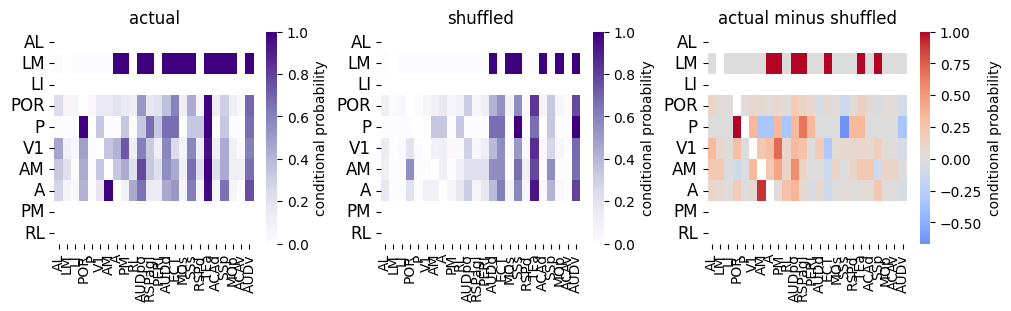

In [69]:

analysis_names =['homogenous_across_cubelet', 'shuff_cubelet']
fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(['cubelet']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        axs[number].set_title(f'{titles[number]}')
        axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        # if analysis_type != 'main':
        #     if number>1:
        #         for ii in data_to_use.index:
        #             for j in data_to_use.columns:
        #                 if p_val_dict[f'shuff_{analysis_type}'].loc[ii, j] > 0.05:
        #                     row_idx = data_to_use.index.get_loc(ii)  # get the index of the row name
        #                     col_idx = data_to_use.columns.get_loc(j)  
        #                     axs[analysis_num, number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))


In [4]:
def get_cosine_sim(matrix, cols, binarize=True):
    cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for col in cols:
        for col_2 in cols:
            if binarize:
                neurons_1 = matrix[matrix[col] >0].astype(bool).mean(axis=0)
                neurons_2 = matrix[matrix[col_2] >0].astype(bool).mean(axis=0)
            else:
                neurons_1 = matrix[matrix[col] >0].mean(axis=0)
                neurons_2 = matrix[matrix[col_2] >0].mean(axis=0)
            neurons_1 =neurons_1.drop([col, col_2])
            neurons_2 =neurons_2.drop([col, col_2])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            cosine_sim = cosine_similarity(bl, bl_2)
            cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
            cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
    np.fill_diagonal(cosine_sim_matrix.values, np.nan)
    return cosine_sim_matrix

In [5]:
cosine_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
for key in analysis_names:
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix_to_comp = all_combined[key].copy()
    all_cols = matrix_to_comp.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    cosine_sim_actual = get_cosine_sim(matrix=matrix_to_comp[cols_reordered], cols=cols)
    #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
    which_type = [s for s in ['cubelet', 'main', 'area'] if s in key]
    which = which_type[0]
    shuffled_cosine = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_cosine_sim_binary__collated.pkl')
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    p_val_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for column_name in shuffled_cosine.columns:
        separated_words = column_name.split(', ')
        if separated_words[0] in cols and separated_words[1] in cols:
            mean_cosine = shuffled_cosine[column_name].mean()
            mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_cosine
            mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_cosine
            val_to_comp = cosine_sim_actual.loc[separated_words[0], separated_words[1]]
            if val_to_comp >= mean_cosine:
                #z_value = (val_to_comp - mean_corr) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_cosine[column_name] if value > val_to_comp)/len(shuffled_cosine))*2
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
            elif val_to_comp < mean_cosine:
                #z_value = (mean_corr - val_to_comp) / shuffled_corr[column_name].std()
                p_val = (sum(1 for value in shuffled_cosine[column_name] if value < val_to_comp)/len(shuffled_cosine))*2    
            #p_val = scipy.stats.norm.sf(abs(z_value))*2
            p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
            p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val    
            
    np.fill_diagonal(mean_val_matrix.values, np.nan)
    np.fill_diagonal(p_val_matrix.values, np.nan)
    number_tests = len(cols)* (len(cols_reordered)-1)
    p_val_matrix = p_val_matrix*number_tests #bonferroni correction
    p_val_dict[key] =p_val_matrix
    cosine_dict[key] =cosine_sim_actual
    cosine_dict[f'{key}_shuffled'] =mean_val_matrix


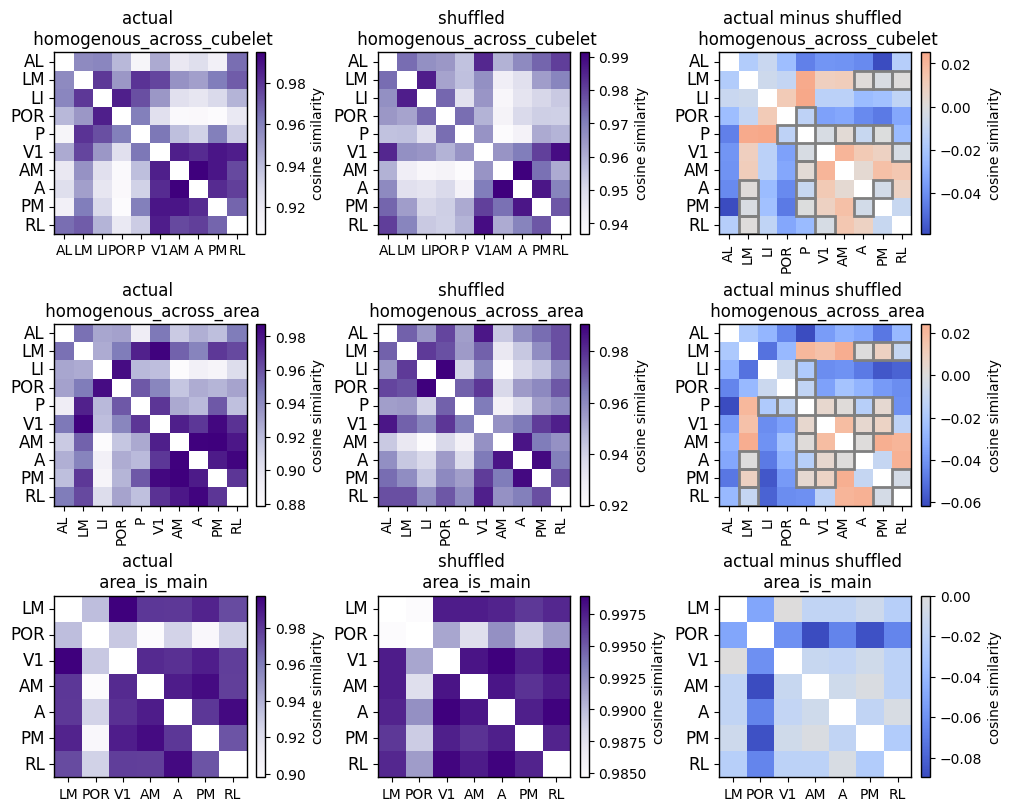

In [6]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, key in enumerate(analysis_names):
    orig_df = cosine_dict[key].copy(deep=True)
    shuf_df = cosine_dict[f'{key}_shuffled'].copy(deep=True)
    combined_dif = orig_df - shuf_df
    if key == 'homogenous_across_cubelet':
        to_compare_cosine = combined_dif
    dfs = [orig_df, shuf_df, combined_dif]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        if number<2:
            sb.heatmap(
                    ax=axs[analysis_num, number], 
                    data=fpf.convert_matrix_names(dfs[number]), 
                    cmap='Purples',
                    xticklabels=True, 
                    yticklabels=True, 
                    cbar_kws={'label': 'cosine similarity'}
                )
        else:
                sb.heatmap(
                    ax=axs[analysis_num, number], 
                    data=fpf.convert_matrix_names(dfs[number]), 
                    cmap='coolwarm', center=0,
                    xticklabels=True, 
                    yticklabels=True, 
                    cbar_kws={'label': 'cosine similarity'}
                )
        axs[analysis_num, number].set_title(f'{titles[number]} \n {key}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if key != 'area_is_main':
            if number>1:
                for ii in data_to_use.index:
                    for j in data_to_use.columns:
                        if p_val_dict[key].loc[ii, j] > 0.05:
                            row_idx = data_to_use.index.get_loc(ii)  # get the index of the row name
                            col_idx = data_to_use.columns.get_loc(j)  
                            axs[analysis_num, number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

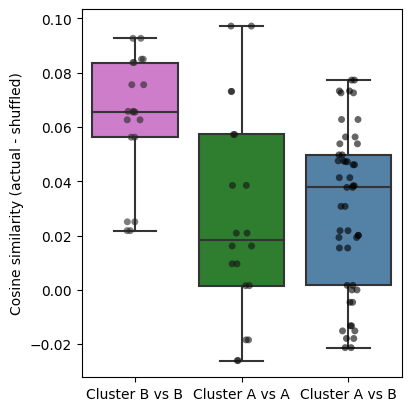

In [40]:
from scipy.stats import ttest_ind, mannwhitneyu
def significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'ns'  # not significant
def add_significance_line(ax, x1, x2, y, significance, offset=0.05):
    """
    Draws a significance line with stars between two x coordinates.
    ax: The axes to draw the line on.
    x1, x2: The positions of the two groups being compared.
    y: The height at which the line should be drawn.
    significance: The significance label to put above the line.
    offset: Offset between the line and the text.
    """
    ax.plot([x1, x1, x2, x2], [y, y + offset, y + offset, y], lw=1.5, color='black')
    ax.text((x1 + x2) * 0.5, y + offset, significance, ha='center', va='bottom', color='grey', fontsize=16)

fig, axs = plt.subplots(1, figsize=(4, 4), constrained_layout=True)


combined_dif = to_compare_cosine
colors = ['orchid', 'forestgreen', 'steelblue']    
for numero, which_shuff in enumerate([combined_dif]):
    # ventral_stream = ['LM', 'LI', 'POR', 'P']  # Update to correct dorsal areas
    # dorsal_stream = ['AL', 'AM', 'A', 'PM', 'RL']  # Update to correct ventral areas
    ventral_stream = ['AL', 'LM', 'LI', 'POR', 'P']  # Update to correct dorsal areas
    dorsal_stream = ['V1', 'AM', 'A', 'PM', 'RL']
    which_shuff = fpf.convert_matrix_names(which_shuff)
    dorsal_stream = [col for col in dorsal_stream if col in which_shuff.columns]
    ventral_stream = [col for col in ventral_stream if col in which_shuff.columns]

    # Extract intra-stream values (Dorsal-Dorsal and Ventral-Ventral)
    dorsal_intra = which_shuff.loc[dorsal_stream, dorsal_stream].values.flatten()
    ventral_intra = which_shuff.loc[ventral_stream, ventral_stream].values.flatten()
    dorsal_intra = [x for x in dorsal_intra if not np.isnan(x)]
    ventral_intra = [x for x in ventral_intra if not np.isnan(x)]
    # Extract inter-stream values (Dorsal-Ventral and Ventral-Dorsal)
    dorsal_to_ventral = which_shuff.loc[dorsal_stream, ventral_stream].values.flatten()
    ventral_to_dorsal = which_shuff.loc[ventral_stream, dorsal_stream].values.flatten()

    # Combine dorsal-to-ventral and ventral-to-dorsal into one group
    inter_stream = np.concatenate([dorsal_to_ventral, ventral_to_dorsal])

    # Perform a statistical comparison within each group
    # Compare dorsal-to-dorsal vs ventral-to-ventral
    t_stat_dd_vv, p_value_dd_vv = ttest_ind(dorsal_intra, ventral_intra, nan_policy='omit')
    u_stat_dd_vv, p_value_mw_dd_vv = mannwhitneyu(dorsal_intra, ventral_intra, alternative='two-sided')

    # Compare dorsal-to-dorsal vs dorsal-to-ventral
    t_stat_dd_dv, p_value_dd_dv = ttest_ind(dorsal_intra, inter_stream, nan_policy='omit')
    u_stat_dd_dv, p_value_mw_dd_dv = mannwhitneyu(dorsal_intra, inter_stream, alternative='two-sided')

    # Compare ventral-to-ventral vs dorsal-to-ventral
    t_stat_vv_dv, p_value_vv_dv = ttest_ind(ventral_intra, inter_stream, nan_policy='omit')
    u_stat_vv_dv, p_value_mw_vv_dv = mannwhitneyu(dorsal_intra, inter_stream, alternative='two-sided')
    data_to_plot = [dorsal_intra, ventral_intra, inter_stream]
    labels = ['Cluster B vs B', 'Cluster A vs A', 'Cluster A vs B']
    max_y = max(max(dorsal_intra), max(ventral_intra), max(inter_stream))+0.02
    sb.boxplot(ax=axs, data=data_to_plot, palette=colors, showfliers=False)
    sb.stripplot(ax=axs, data=data_to_plot, jitter=True, color="black", alpha=0.6)
    significance_dd_vv = significance_stars(p_value_mw_dd_vv)
    #add_significance_line(axs, 0, 1, max_y, significance_dd_vv)

    significance_dd_dv = significance_stars(p_value_mw_dd_dv)
    #add_significance_line(axs, 0, 2, max_y + 0.01, significance_dd_dv)

    significance_vv_dv = significance_stars(p_value_mw_vv_dv)
    #add_significance_line(axs, 1, 2, max_y + 0.02, significance_vv_dv)
    axs.set_xticklabels(labels)
    
    label = 'Cosine similarity (actual - shuffled)'
    axs.set_ylabel(label)
    #axs.set_title(f'{comparing[numero]} for {analysis_type} comparison')
    axs.grid(False)

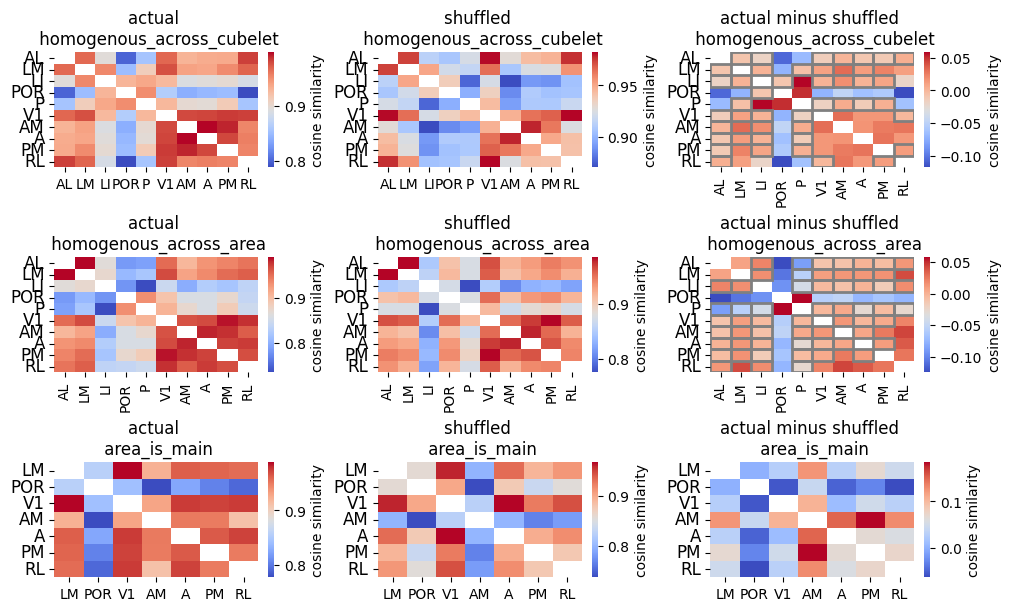

In [ ]:

analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, key in enumerate(analysis_names):
    orig_df = cosine_dict[key].copy(deep=True)
    shuf_df = cosine_dict[f'{key}_shuffled'] .copy(deep=True)
    combined_dif = orig_df - shuf_df
    
    dfs = [orig_df, shuf_df, combined_dif]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(dfs[number]), 
                cmap='coolwarm',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'cosine similarity'}
            )
        axs[analysis_num, number].set_title(f'{titles[number]} \n {key}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if key != 'area_is_main':
            if number>1:
                for ii in data_to_use.index:
                    for j in data_to_use.columns:
                        if p_val_dict[key].loc[ii, j] > 0.05:
                            row_idx = data_to_use.index.get_loc(ii)  # get the index of the row name
                            col_idx = data_to_use.columns.get_loc(j)  
                            axs[analysis_num, number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=2))


In [22]:
#for area in ventral stream

,VISl,VISpor,VISp,VISam,VISa,VISpm,VISrl
VISl,NaN,-0.064394,-0.046206,0.078276,-0.067906,-0.016572,-0.057963
VISpor,-0.064394,NaN,-0.107638,0.019623,-0.106533,-0.097708,-0.105421
VISp,-0.046206,-0.107638,NaN,0.057531,-0.093093,-0.030855,-0.091345
VISam,0.078276,0.019623,0.057531,NaN,0.131022,0.154841,0.091852
VISa,-0.067906,-0.106533,-0.093093,0.131022,NaN,-0.011869,0.000408
VISpm,-0.016572,-0.097708,-0.030855,0.154841,-0.011869,NaN,-0.039674
VISrl,-0.057963,-0.105421,-0.091345,0.091852,0.000408,-0.039674,NaN
